In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

NOTE : Data is too large to be stored on github

In [2]:
train_file_path = 'resources/AD_train.csv'
test_file_path = 'resources/AD_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
# test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

### VARIABLES

In [3]:
CORRELATION_THRESHOLD = 0.75
MAX_FLOAT = np.finfo(np.float_).max

train_data_norm = train_data.copy()
for column in train_data_norm.columns:
    if column not in ['Timestamp', 'amp', 'ack']:  # Exclude non-sensor columns

        train_data_norm[column] = pd.to_numeric(train_data_norm[column], errors='coerce')
        
        min_val = np.min(train_data_norm[column])
        max_val = np.max(train_data_norm[column])
        train_data_norm[column] = (train_data_norm[column] - min_val) / (max_val - min_val)

test_data_norm = test_data.copy()
for column in test_data_norm.columns:
    if column not in ['Timestamp', 'amp', 'ack']:  # Exclude non-sensor columns

        test_data_norm[column] = pd.to_numeric(test_data_norm[column], errors='coerce')
        
        min_val = np.min(test_data_norm[column])
        max_val = np.max(test_data_norm[column])
        test_data_norm[column] = (test_data_norm[column] - min_val) / (max_val - min_val)

train_data_num = train_data.drop(columns=['Timestamp', 'Normal/Attack'], axis=1).sort_index(axis=1)
test_data_num = test_data.drop(columns=['Timestamp', 'Normal/Attack'], axis=1).sort_index(axis=1)

### Methods

In [4]:
def visualize_sensor_data(df, window=None, sensors=None, title='Sensor Data Visualization'):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title(title)
    plt.legend()

    plt.show()

In [5]:
def visualize_residuals(df, title="Residuals (Downsampled)", threshold=0):
    plt.figure(figsize=(15, 8))
    plt.plot(df)
    plt.xlabel("point #")
    plt.ylabel("Residual")
    plt.title(title)
    if (threshold > 0):
        plt.axhline(y=threshold, color='r', linestyle='--' ,label="Anomaly Threshold")
    plt.show()

In [6]:
def visualize_anomalies(df, title="Residuals (Downsampled)", threshold=0):
    plt.figure(figsize=(15, 8))
    
    # Plot the residuals
    plt.plot(df, label="Residuals")
    plt.xlabel("point #")
    plt.ylabel("Residual")
    plt.title(title)

    # find top and bottom of graph
    y_min, y_max = plt.ylim()

    # Add horizontal line for the threshold
    if threshold > 0:
        plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")

    # Iterate over the dataframe to find and mark anomalies
    for index, value in enumerate(df.iloc[:, 0]):  
        if value > threshold:
            # Draw a red box for each anomaly
            plt.gca().add_patch(plt.Rectangle((index, y_min), 1, y_max - y_min, linewidth=1, edgecolor='r', facecolor='r', alpha=0.3))

    plt.legend()
    plt.show()

In [7]:
def plot_correlation_heatmap(df, x_columns, y_columns, title="Correlation Heatmap", threshold=CORRELATION_THRESHOLD):
    """
    Plots a heatmap of correlations between specified x and y columns in the DataFrame.

    :param df: Pandas DataFrame containing the data.
    :param x_columns: List of column names for the x-axis.
    :param y_columns: List of column names for the y-axis.
    """
    correlation_matrix = df.corr()

    # Extract the correlations between x and y columns
    correlation_xy = correlation_matrix.loc[y_columns, x_columns]

    # Apply the threshold
    correlation_xy = correlation_xy[correlation_xy.abs() >= threshold]

    # Drop rows and columns where all values are NaN (i.e., all correlations below threshold)
    correlation_xy.dropna(axis=0, how='all', inplace=True)
    correlation_xy.dropna(axis=1, how='all', inplace=True)

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(max(20, len(x_columns)), max(20, len(y_columns))))  # Adjust the size as needed
    cax = ax.imshow(correlation_xy, cmap='coolwarm', interpolation='none', aspect='auto')
    fig.colorbar(cax)

    # Add labels with increased font size
    ax.set_xticks(np.arange(len(x_columns)))
    ax.set_yticks(np.arange(len(y_columns)))
    ax.set_xticklabels(x_columns, rotation=90, fontsize=12)
    ax.set_yticklabels(y_columns, fontsize=12)

    # Add title
    plt.title(title)

    # Show the plot
    plt.show()

In [8]:
def list_correlations(df, x_columns, y_columns, threshold=CORRELATION_THRESHOLD):
    """
    Returns a list of tuples containing the correlations between specified x and y columns in the DataFrame
    above a specified threshold, without duplicating pairs.

    :param df: Pandas DataFrame containing the data.
    :param x_columns: List of column names for the x-axis.
    :param y_columns: List of column names for the y-axis.
    :param threshold: Threshold for correlation values.
    :return: List of tuples in the format (x_column, y_column, correlation_value).
    """
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Initialize an empty list to store the correlations and a set to track processed pairs
    correlations = []
    processed_pairs = set()

    # Iterate over each combination of x and y columns
    for x_col in x_columns:
        for y_col in y_columns:
            if x_col != y_col and (y_col, x_col) not in processed_pairs:  # Exclude self-correlations and processed pairs
                corr_value = correlation_matrix.loc[y_col, x_col]
                # Check if the absolute value of correlation is above the threshold
                if abs(corr_value) >= threshold:
                    correlations.append((x_col, y_col, corr_value))
                    processed_pairs.add((x_col, y_col))

    return correlations

In [9]:
MAX_FLOAT = np.inf


def dynamic_time_warping_optimized(a, b, k):
    n = a.size
    m = b.size
    
    dtw_distance = np.inf
    
    # START ANSWER
    arr = np.ndarray(shape = (len(a), len(b)), dtype = float)


    for j in range(0, len(b)):
        for i in range(max(-k, -j), min(k + 1, n - j)):
            if 0 <= j + i < n:
                arr[j + i][j] = computeCel(arr, j + i, j, a, b)

    

    dtw_distance = np.sqrt(arr[-1][-1])
    # END ANSWER

    return dtw_distance

def computeCel(arr, i, j, a, b):
    #first entry
    if(i == 0 and j == 0):
        return np.square(a[i] - b[j])

    #for the case that i or j are less then 1
    d_above = MAX_FLOAT
    d_left = MAX_FLOAT
    d_top_left = MAX_FLOAT

    d_above = arr[i][j-1] if i > -1 and j > 0 else MAX_FLOAT
    d_left = arr[i-1][j] if i > 0 and j > -1 else MAX_FLOAT
    d_top_left = arr[i-1][j-1] if i > 0 and j > 0 else MAX_FLOAT
    
    return np.square(a[i] - b[j]) + np.min([d_above, d_left, d_top_left])

### Exploration

(496800, 53)
['AIT201', 'AIT202', 'AIT203', 'AIT401', 'AIT402', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'DPIT301', 'FIT101', 'FIT201', 'FIT301', 'FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'FIT601', 'LIT101', 'LIT301', 'LIT401', 'MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304', 'P101', 'P102', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'P501', 'P502', 'P601', 'P602', 'P603', 'PIT501', 'PIT502', 'PIT503', 'UV401']
{'AIT': ['AIT201', 'AIT202', 'AIT203', 'AIT401', 'AIT402', 'AIT501', 'AIT502', 'AIT503', 'AIT504'], 'DPIT': ['DPIT301'], 'FIT': ['FIT101', 'FIT201', 'FIT301', 'FIT401', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'FIT601'], 'LIT': ['LIT101', 'LIT301', 'LIT401'], 'MV': ['MV101', 'MV201', 'MV301', 'MV302', 'MV303', 'MV304'], 'P': ['P101', 'P102', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'P301', 'P302', 'P401', 'P402', 'P403', 'P404', 'P501', 'P502', 'P601', 'P602', 'P603'], 'PIT': ['PIT501', 'PIT502', 'PIT503'], '

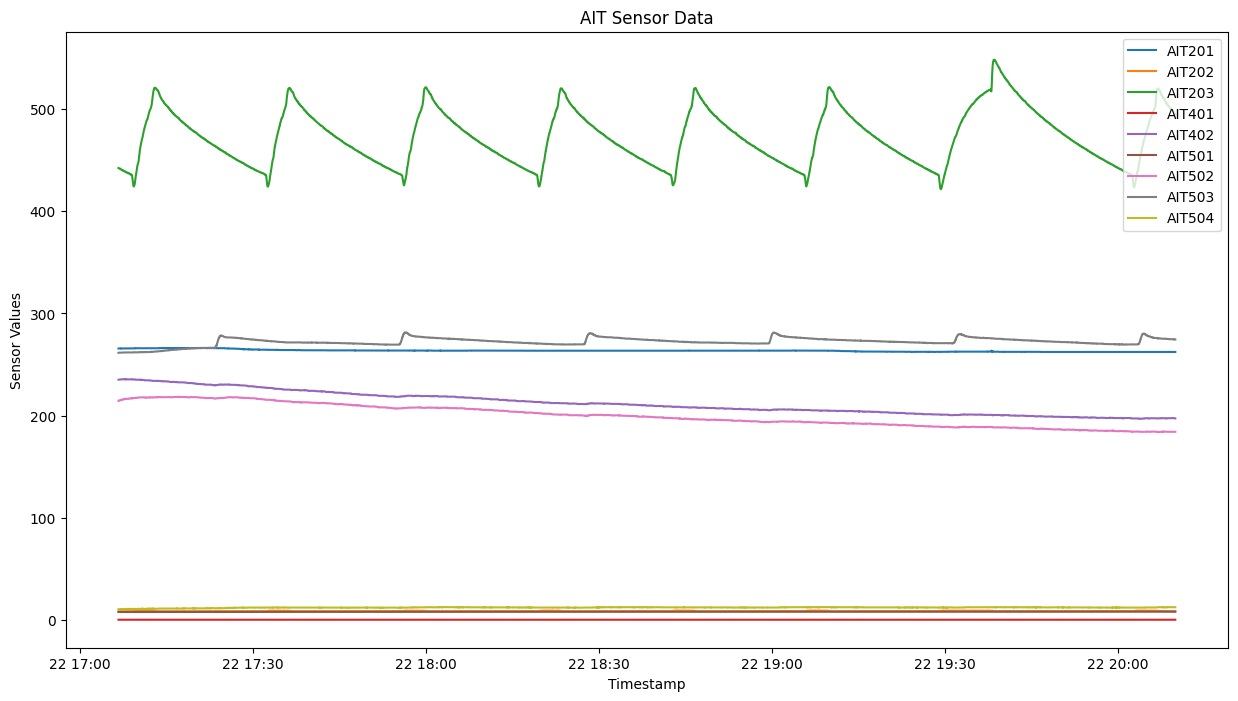

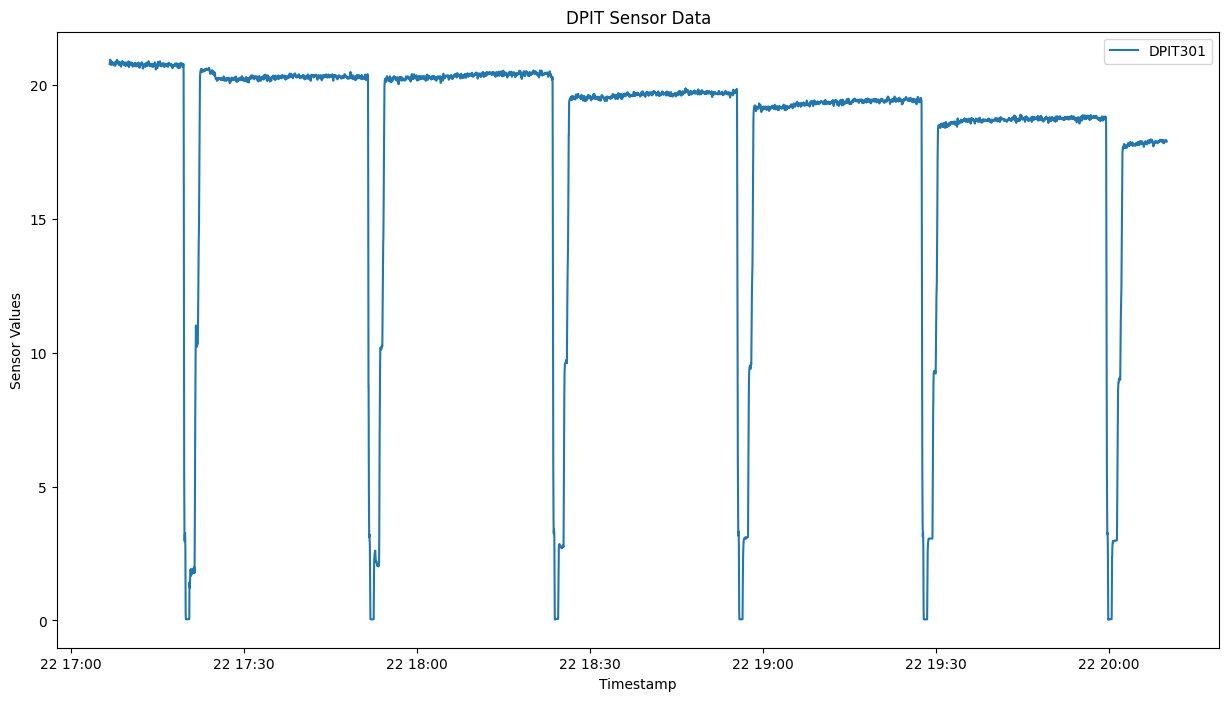

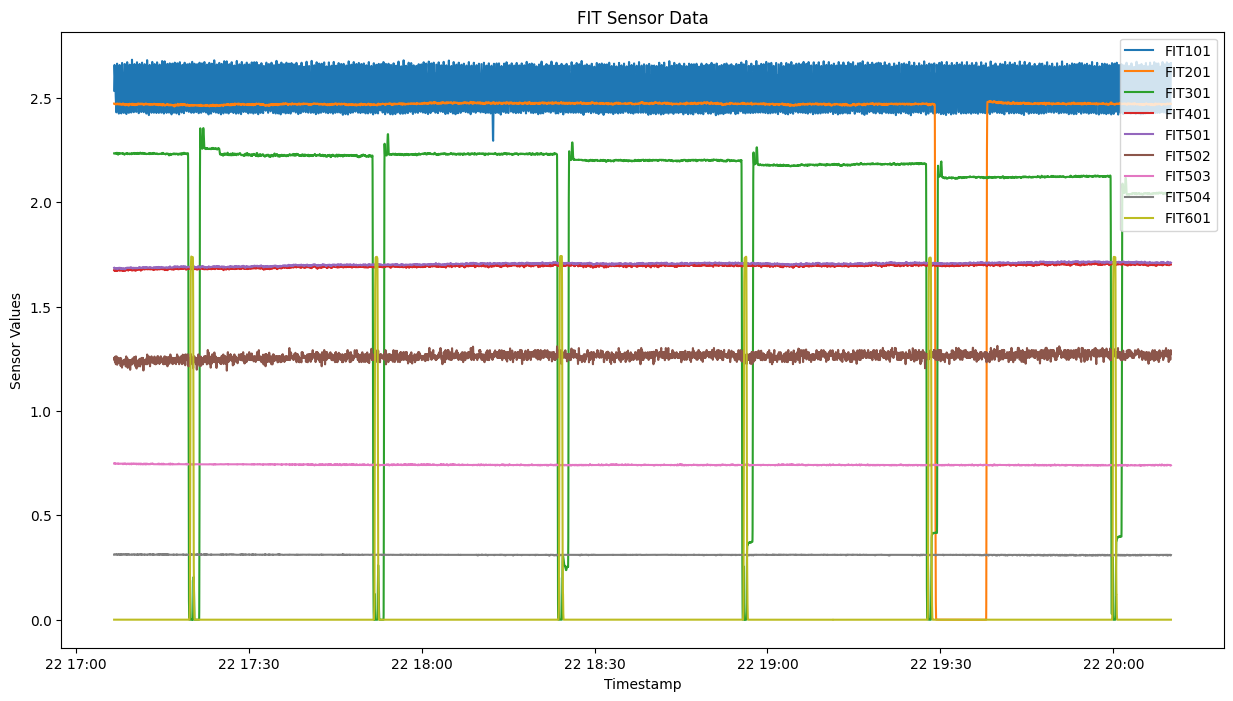

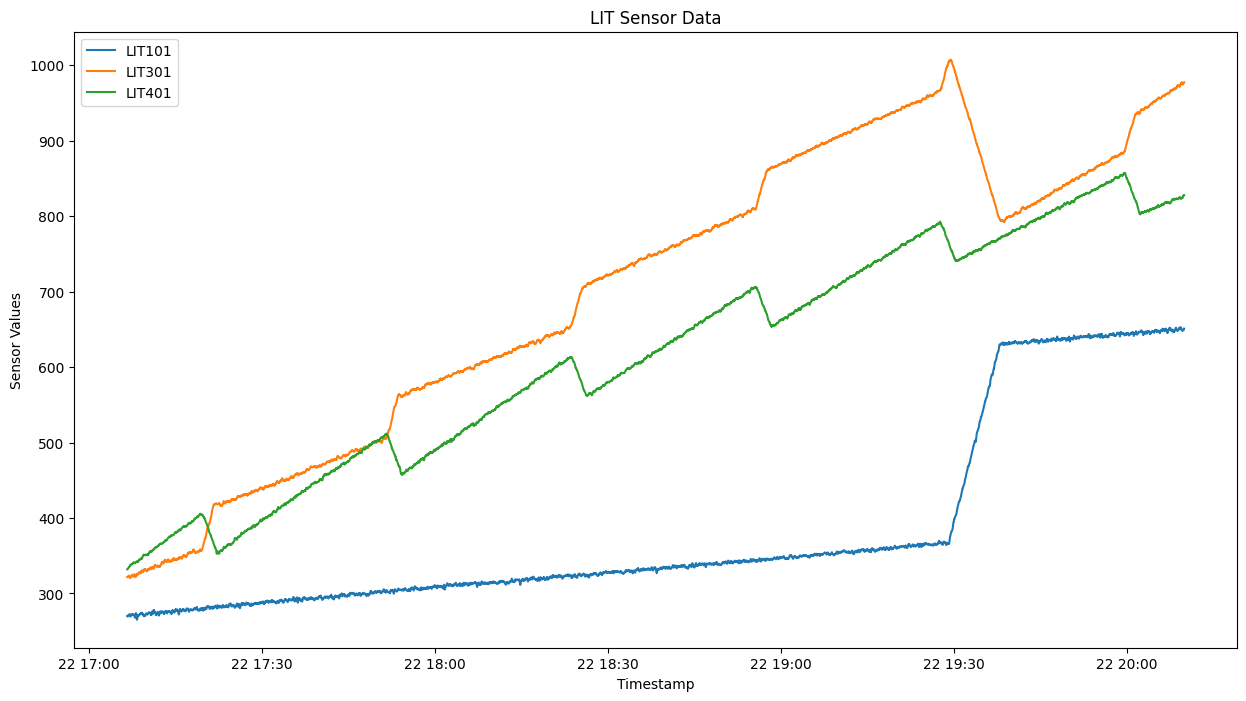

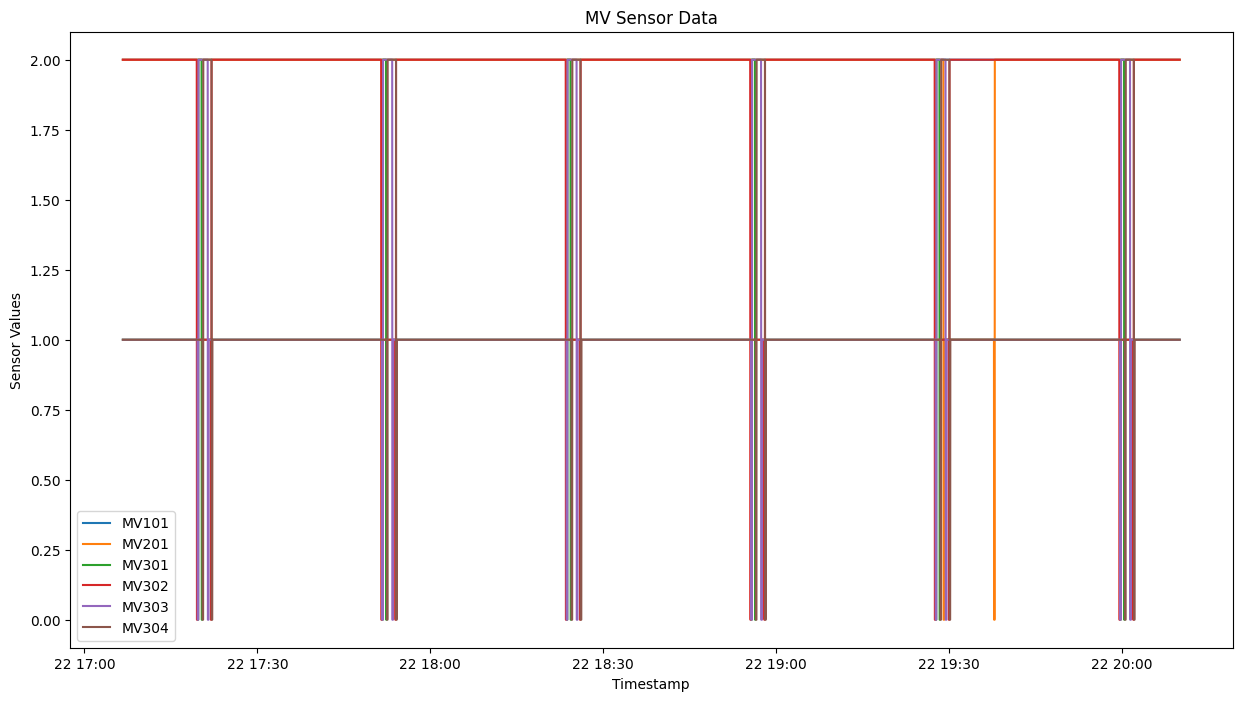

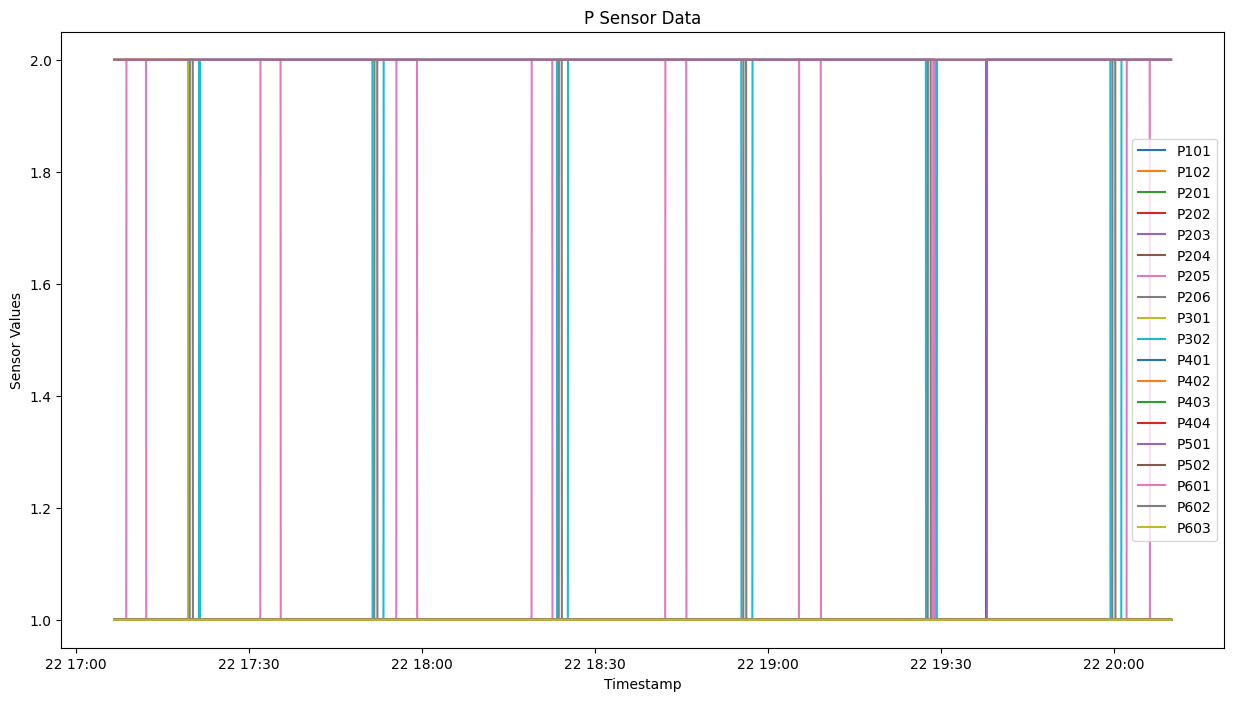

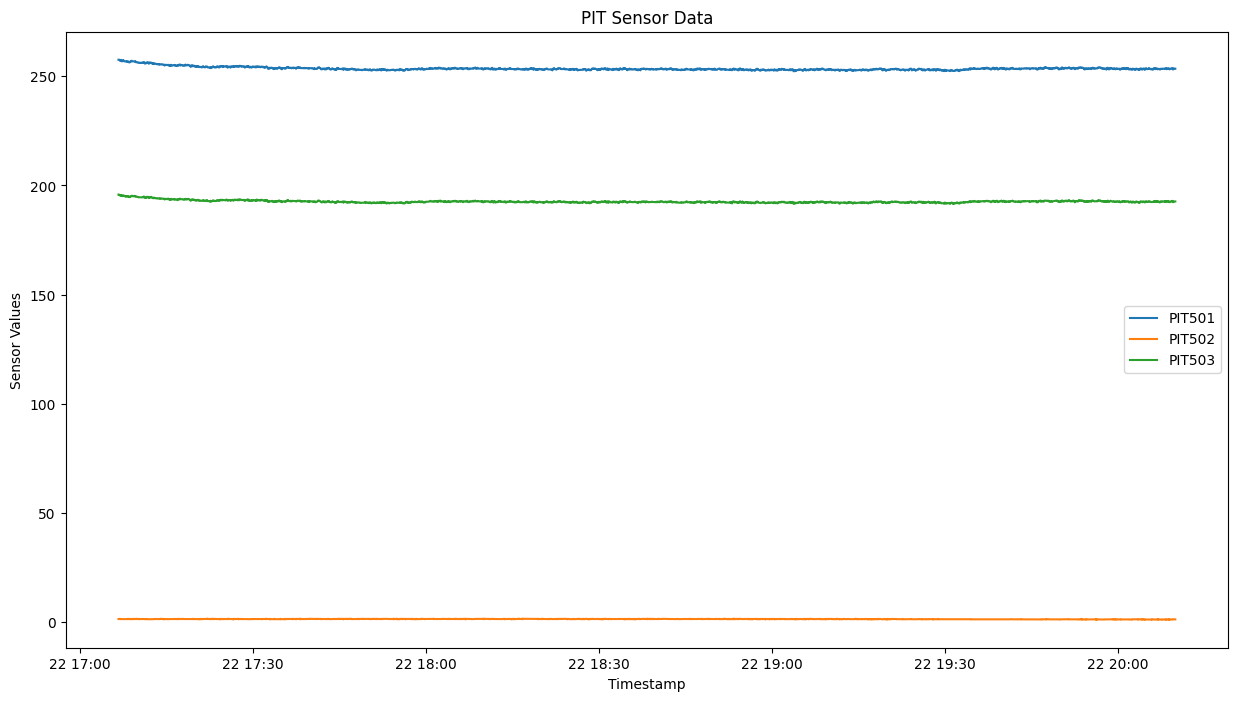

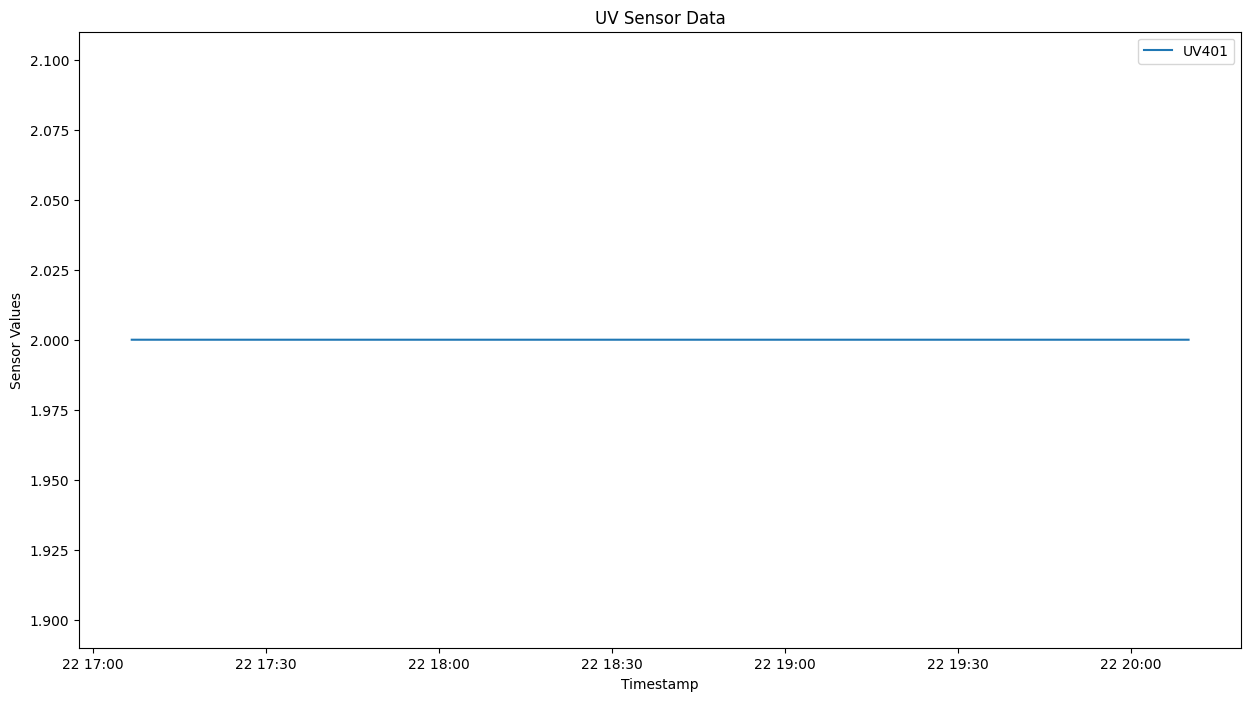

In [10]:
## Intial data exploration and processing

## print shape
print(train_data.shape)

## get sensor names
sensors = train_data_num.columns.to_list()

## Group sensors by prefix
sensor_prefix = [s[:-3] for s in sensors]
sensors_grouped = {p: [] for p in sensor_prefix}
for s in sensors:
    sensors_grouped[s[:-3]].append(s)

## print sensor name info
print(sensors)
print(sensors_grouped)
print(set(sensor_prefix))

for pref, pref_sensors in sensors_grouped.items():
    visualize_sensor_data(train_data, window=(4000, 15000), sensors=pref_sensors, title=f"{pref} Sensor Data")


{'201': ['AIT201', 'FIT201', 'MV201', 'P201'], '202': ['AIT202', 'P202'], '203': ['AIT203', 'P203'], '401': ['AIT401', 'FIT401', 'LIT401', 'P401', 'UV401'], '402': ['AIT402', 'P402'], '501': ['AIT501', 'FIT501', 'P501', 'PIT501'], '502': ['AIT502', 'FIT502', 'P502', 'PIT502'], '503': ['AIT503', 'FIT503', 'PIT503'], '504': ['AIT504', 'FIT504'], '301': ['DPIT301', 'FIT301', 'LIT301', 'MV301', 'P301'], '101': ['FIT101', 'LIT101', 'MV101', 'P101'], '601': ['FIT601', 'P601'], '302': ['MV302', 'P302'], '303': ['MV303'], '304': ['MV304'], '102': ['P102'], '204': ['P204'], '205': ['P205'], '206': ['P206'], '403': ['P403'], '404': ['P404'], '602': ['P602'], '603': ['P603']}
{'404', '603', '303', '402', '304', '602', '205', '102', '401', '501', '601', '206', '203', '504', '101', '502', '503', '403', '301', '302', '204', '202', '201'}


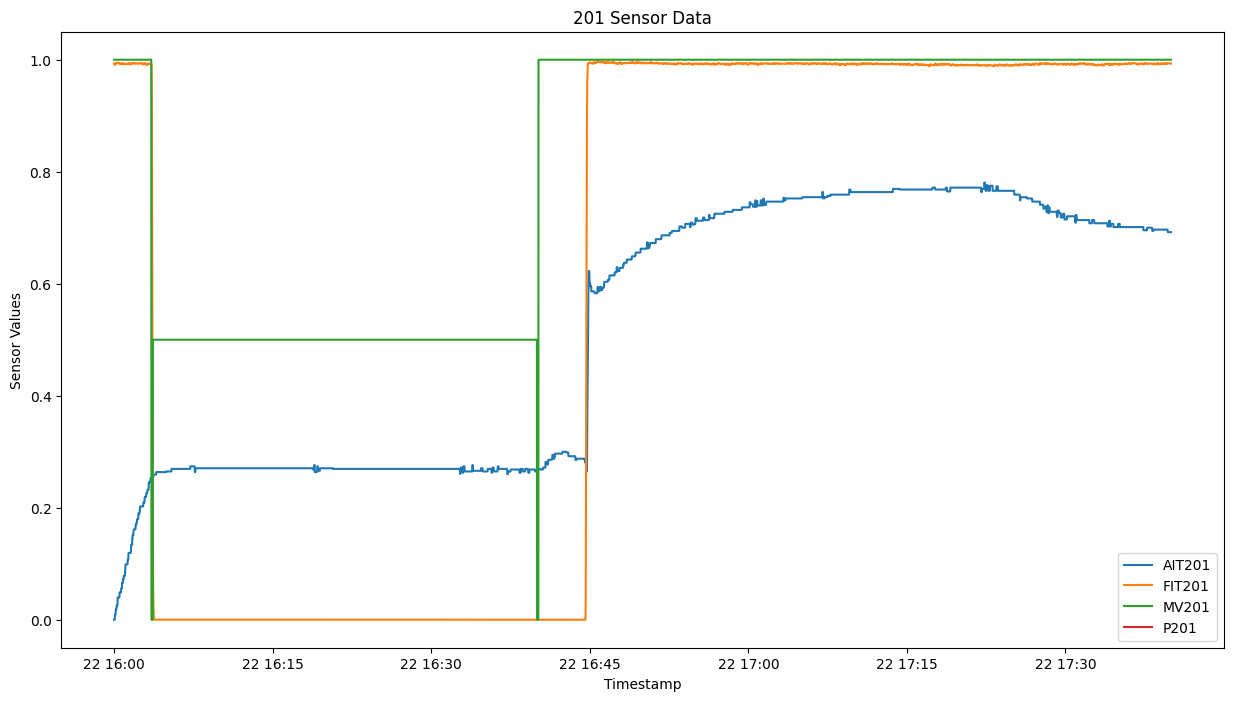

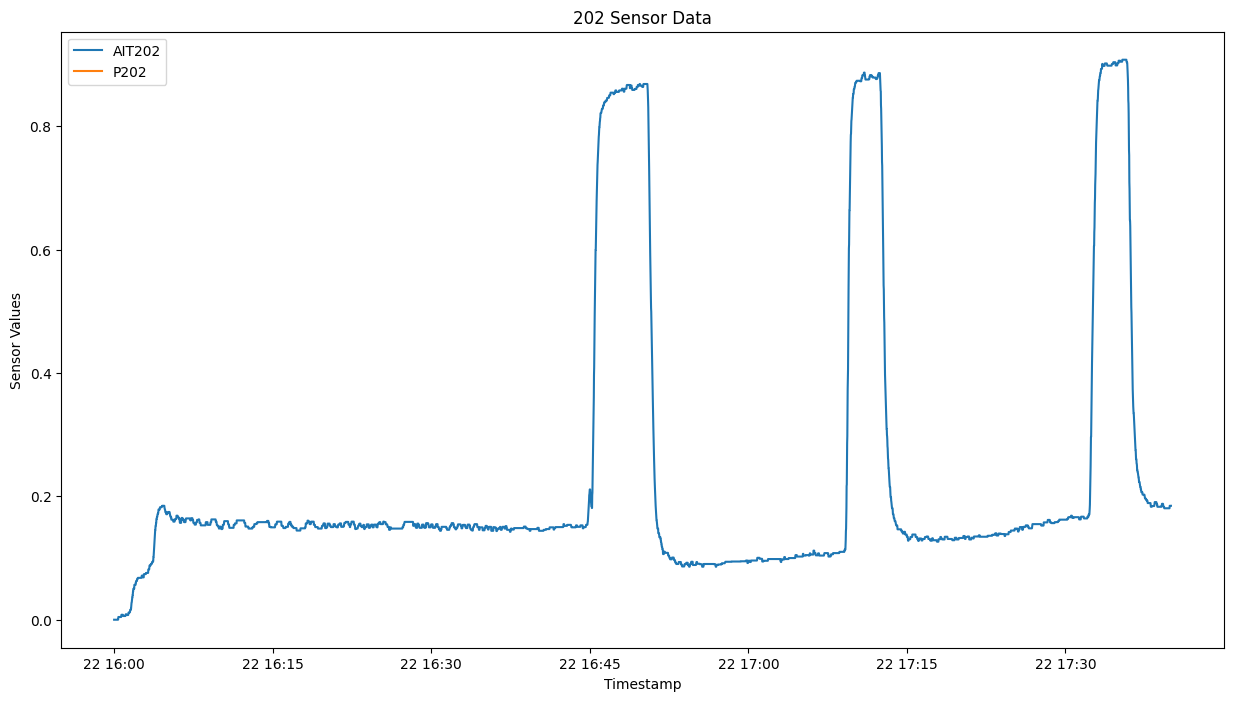

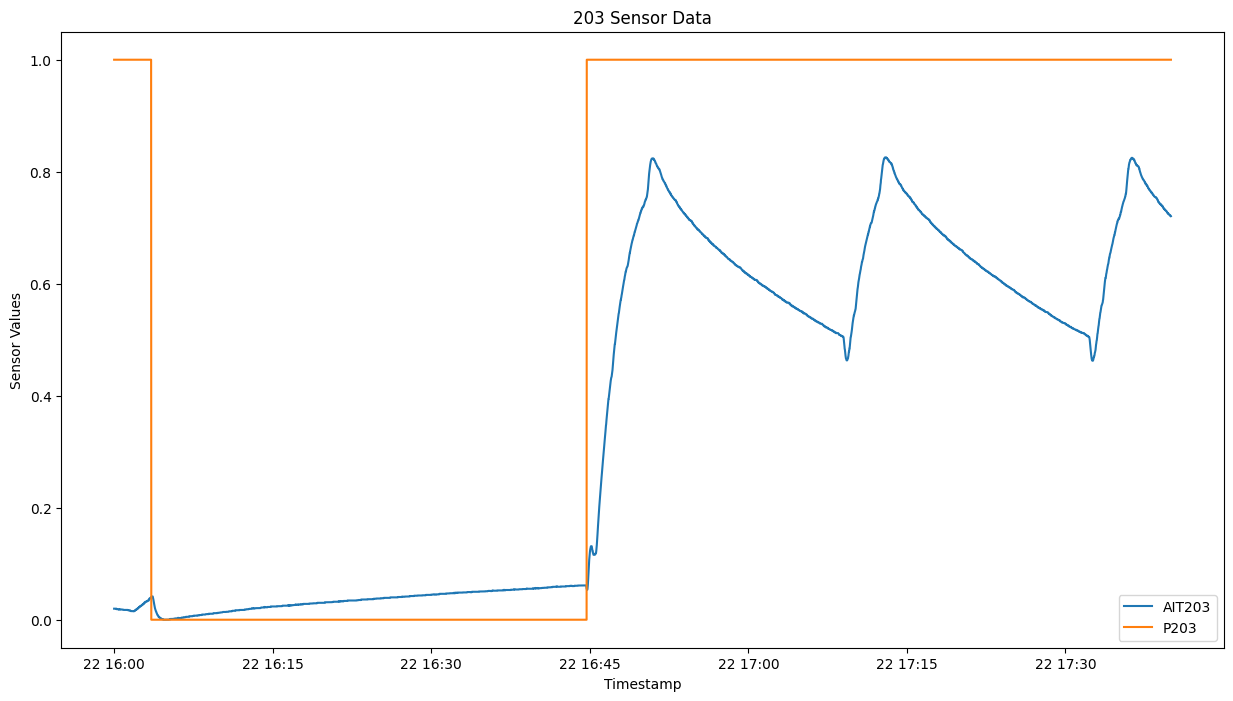

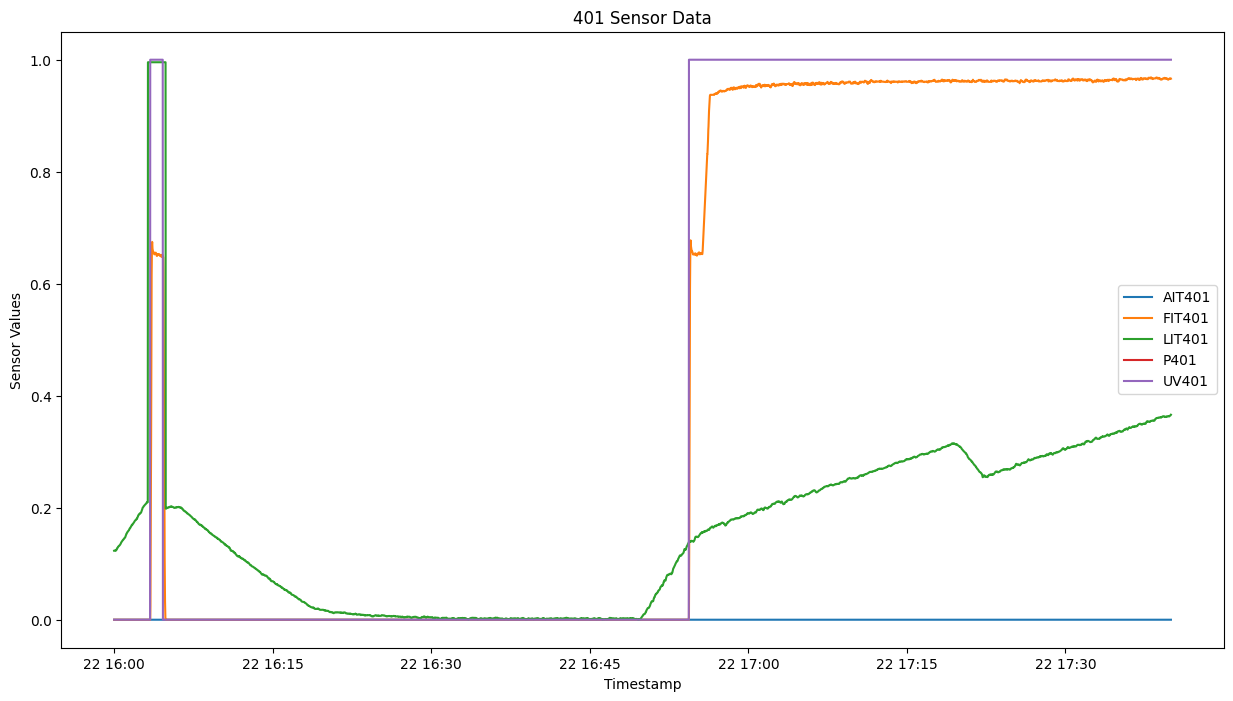

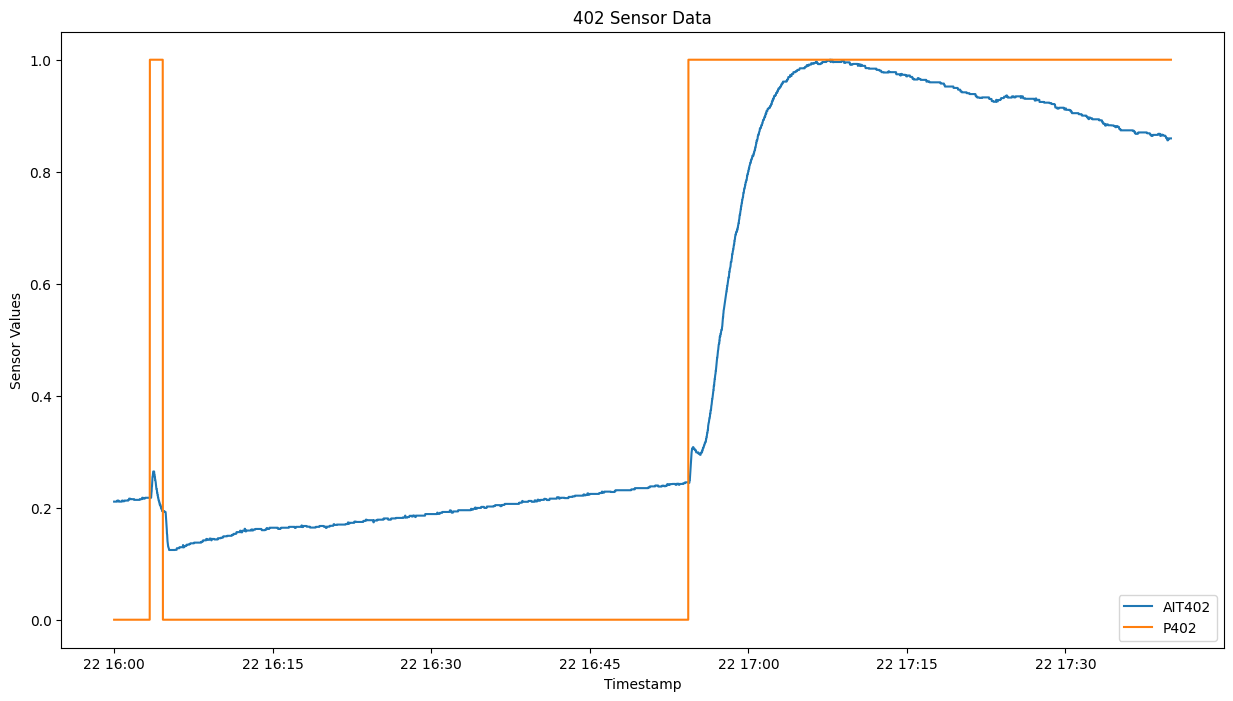

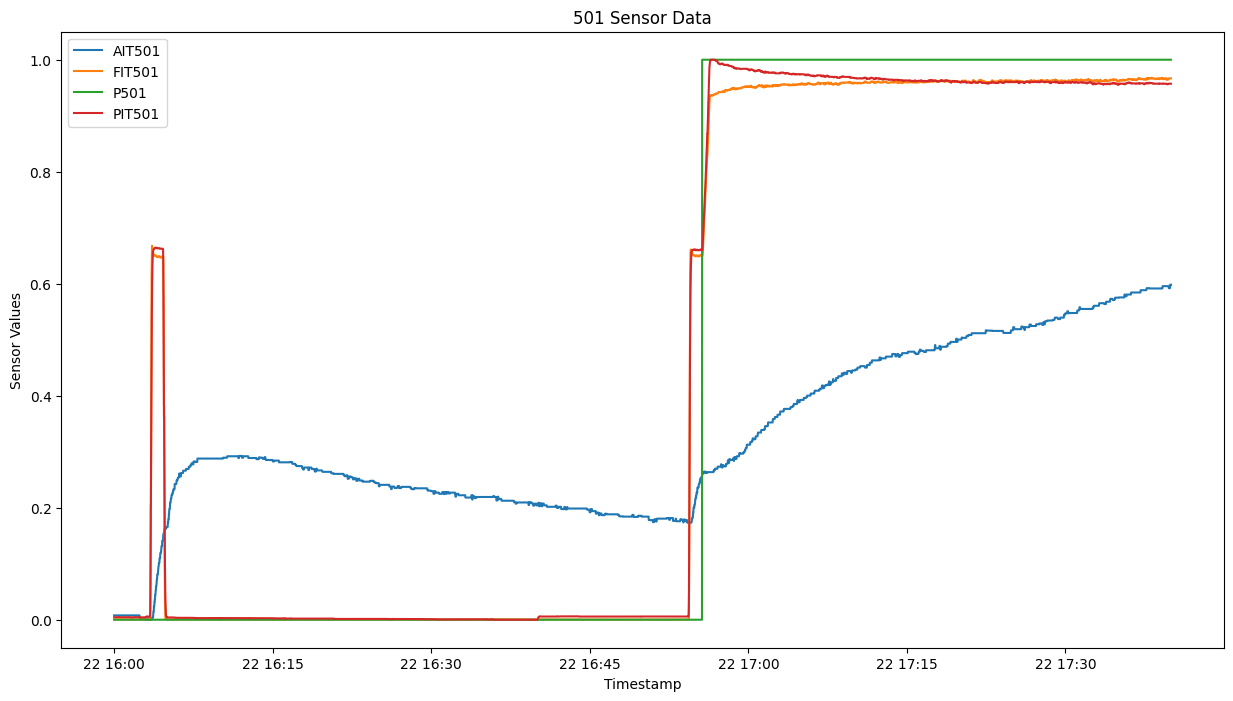

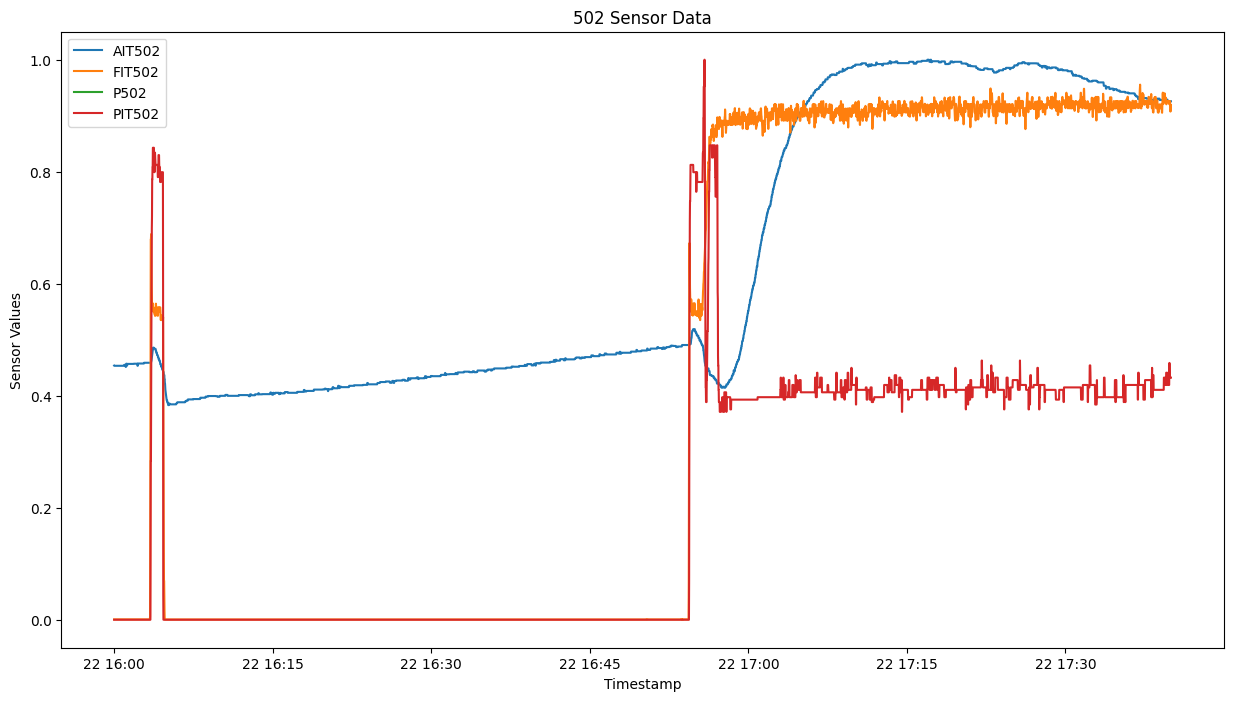

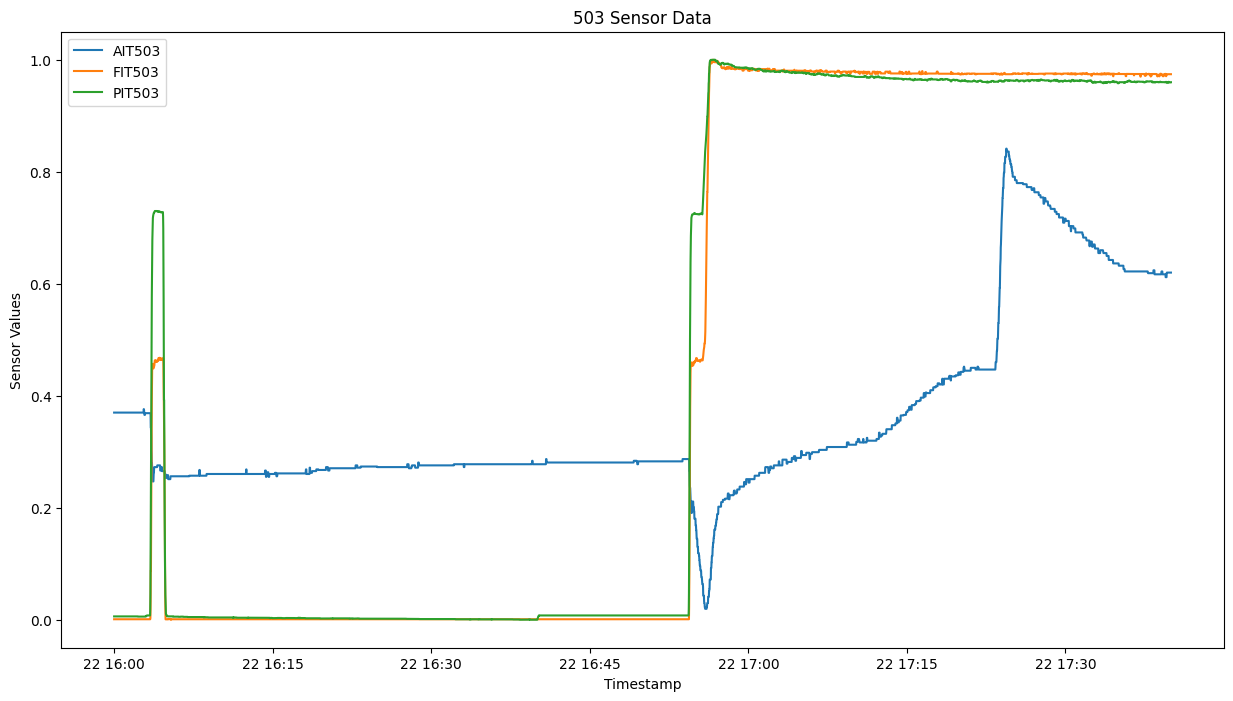

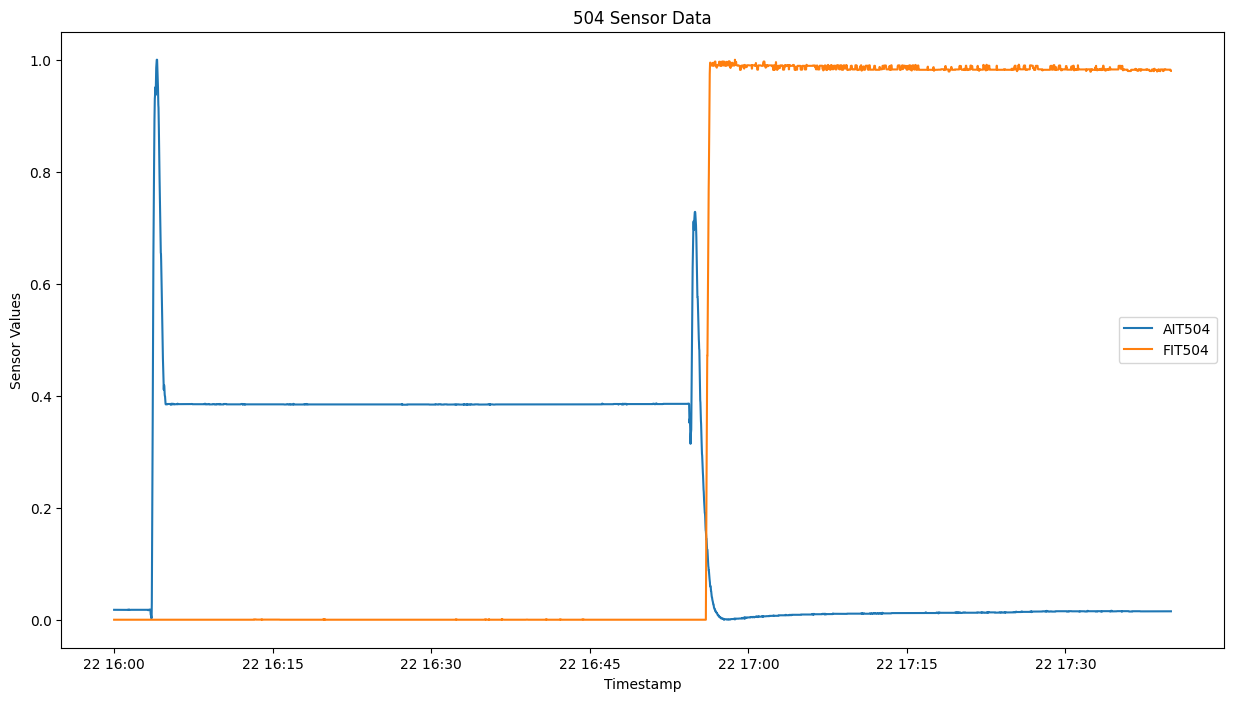

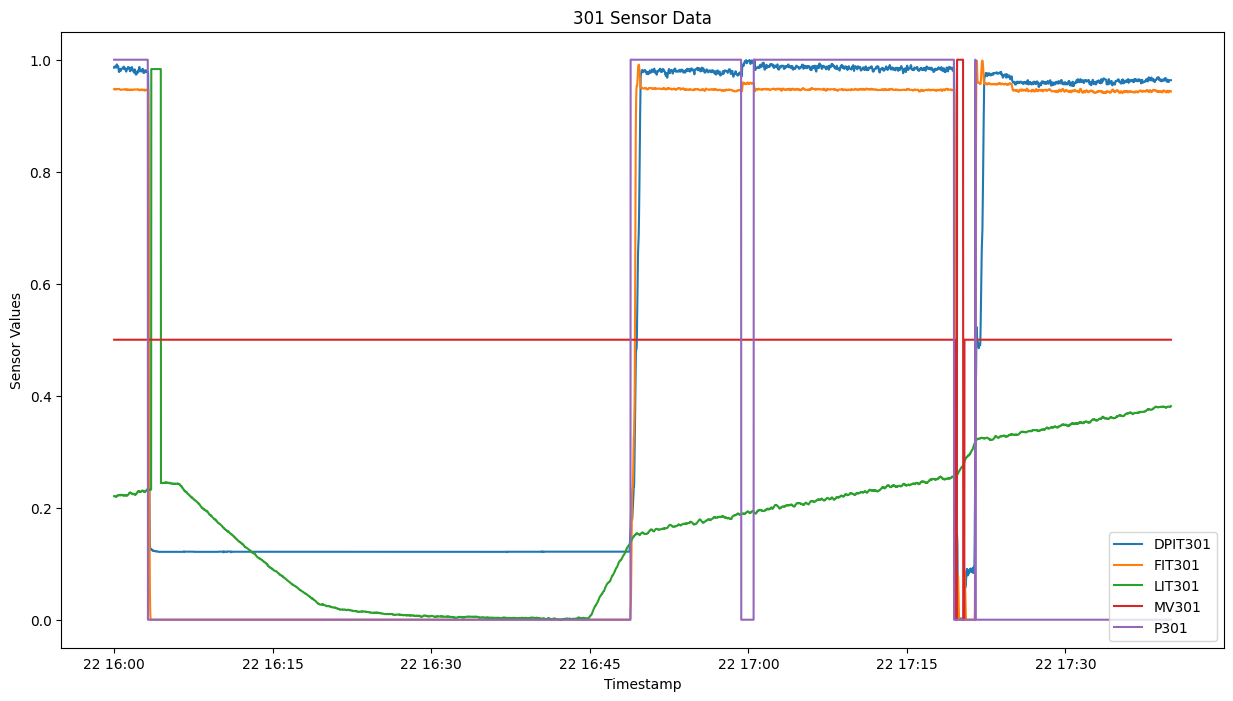

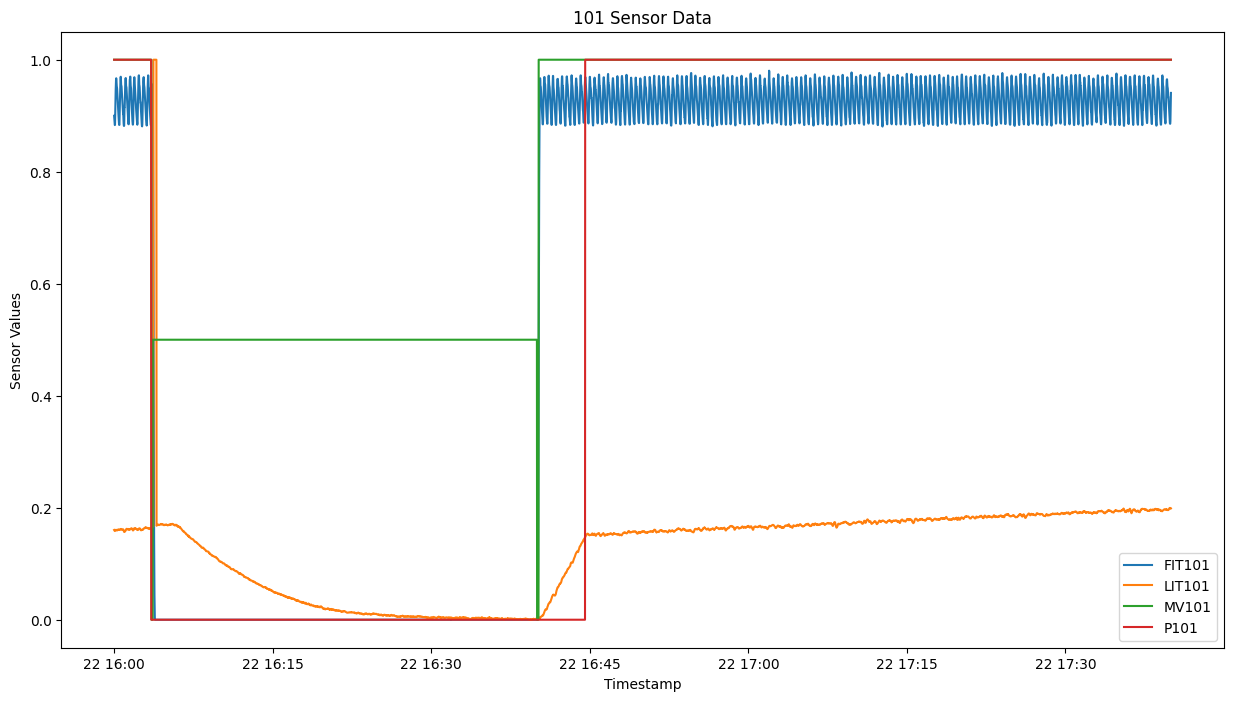

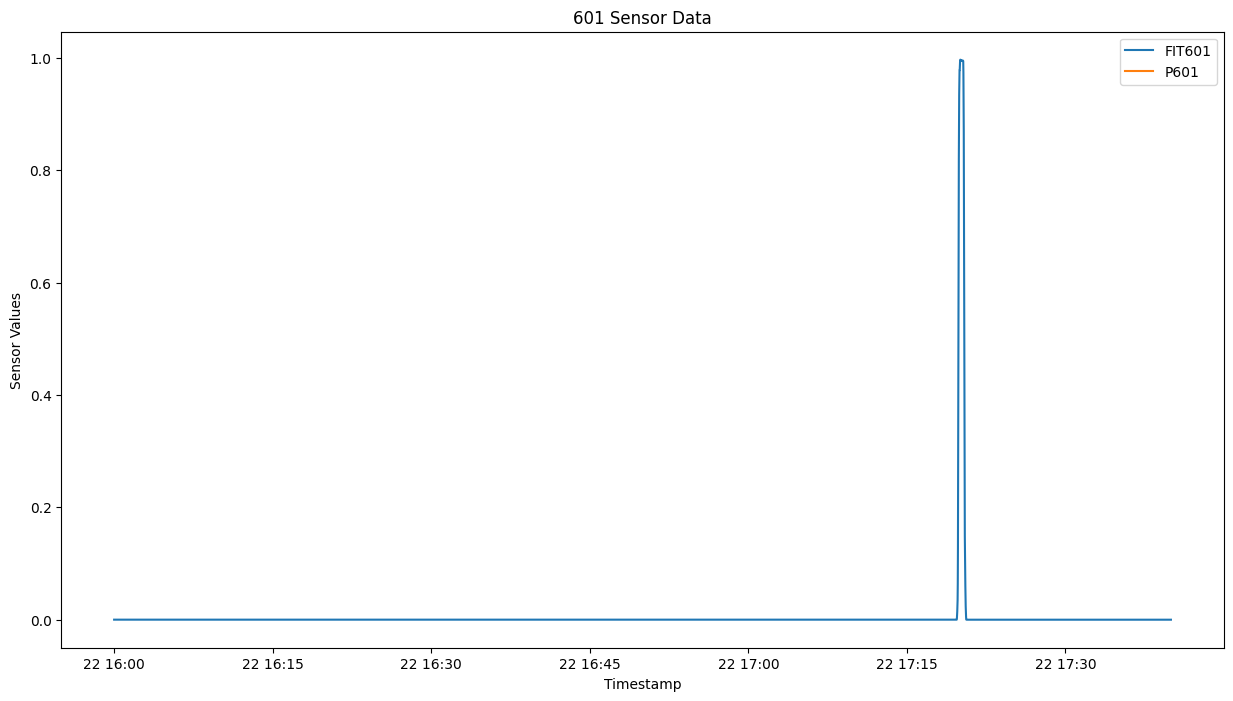

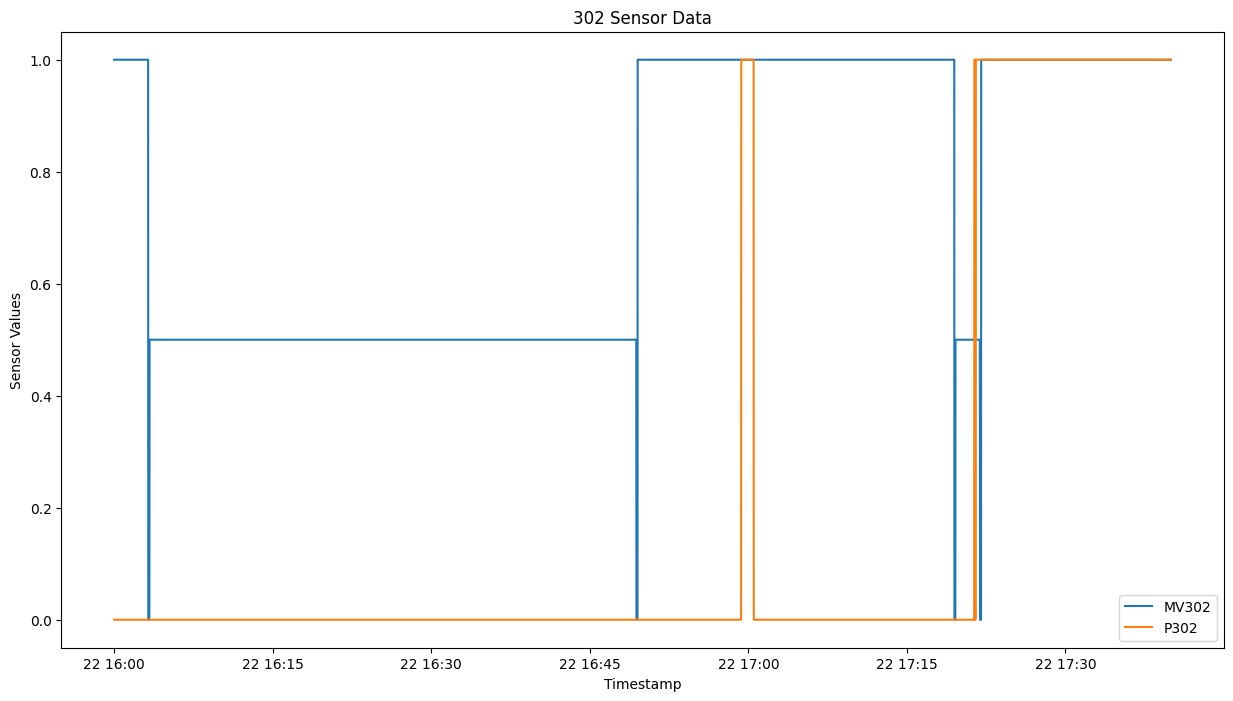

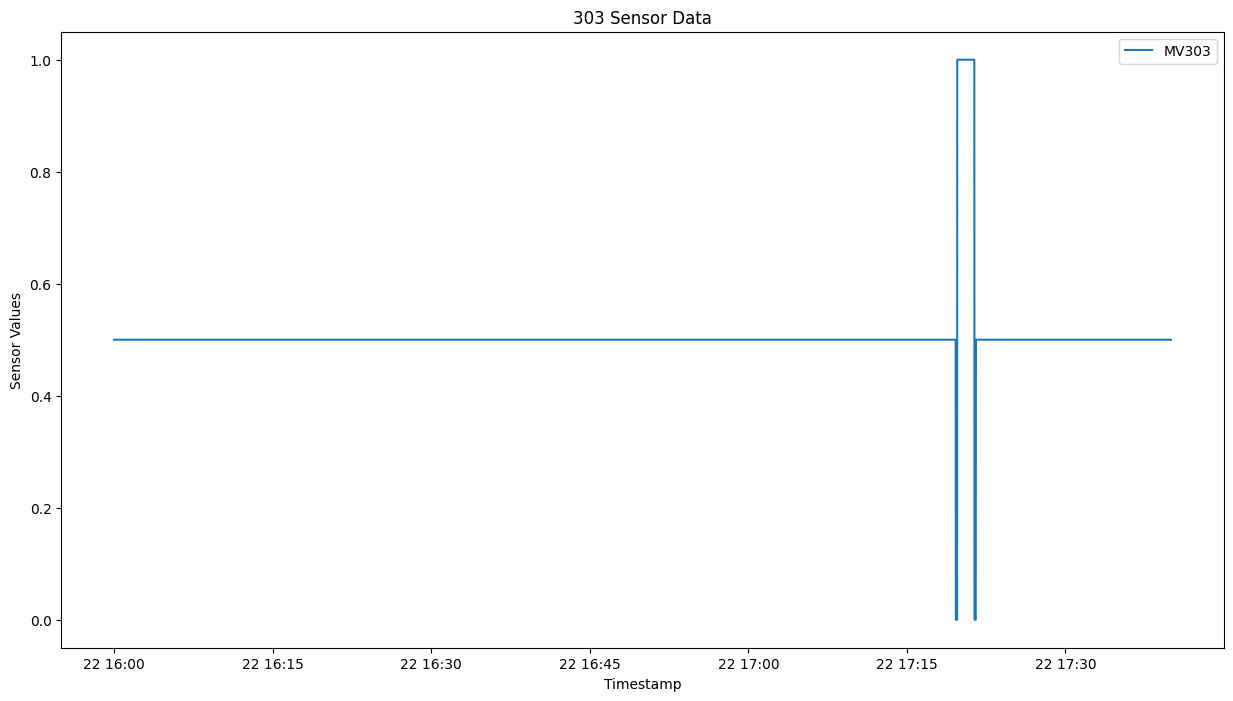

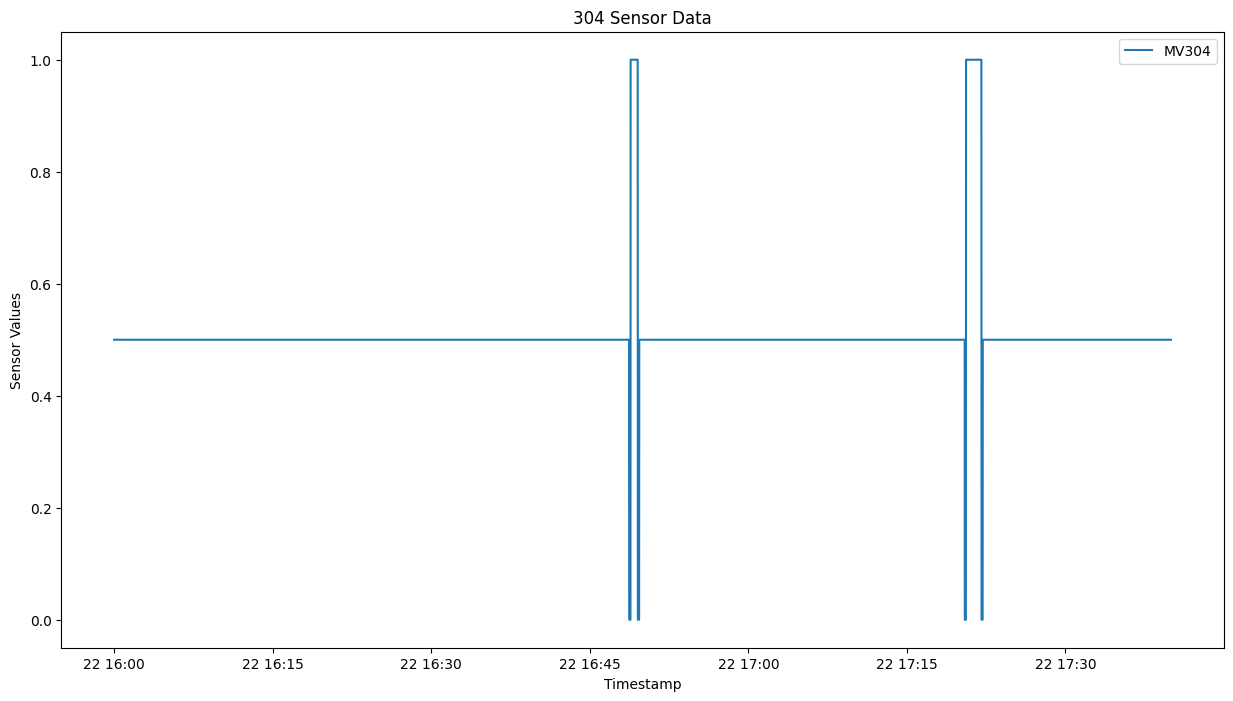

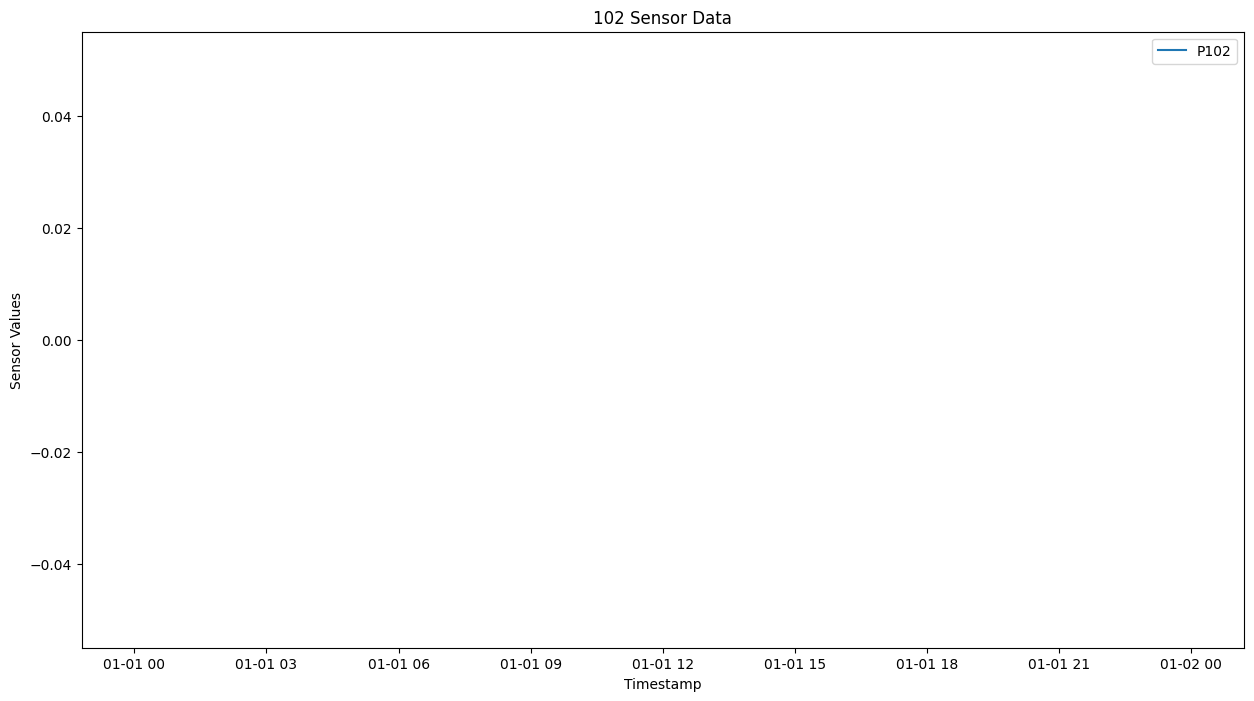

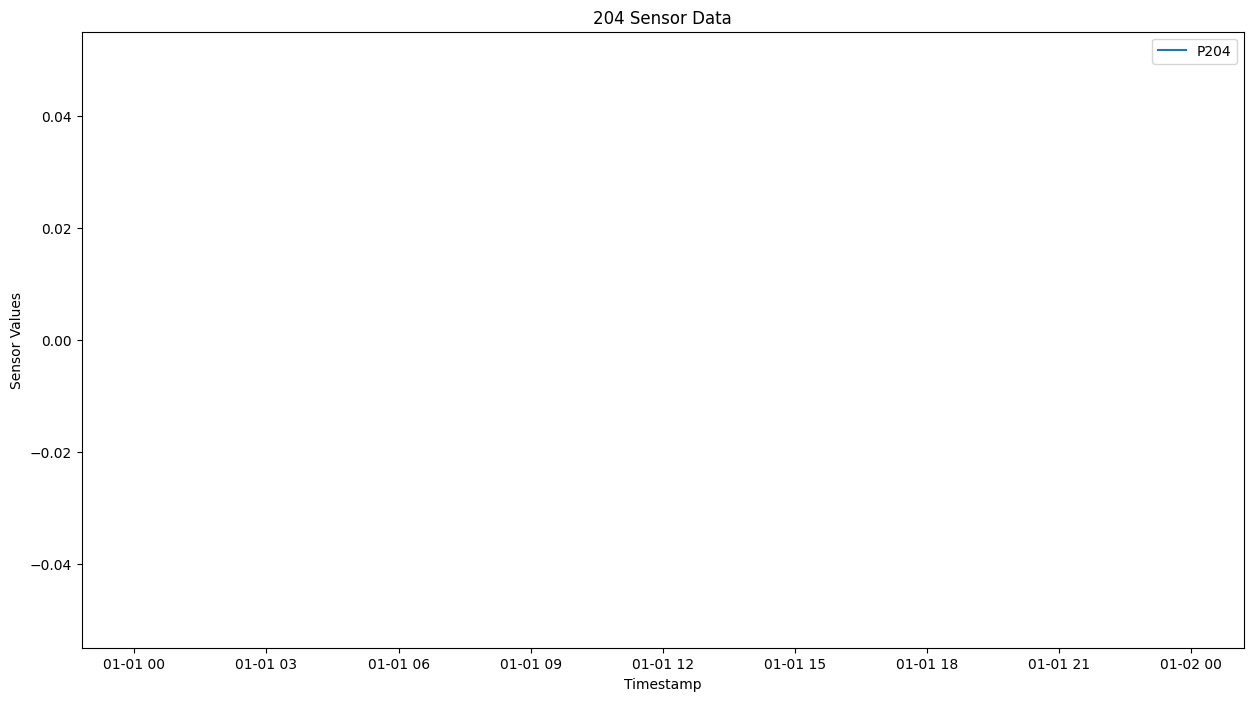

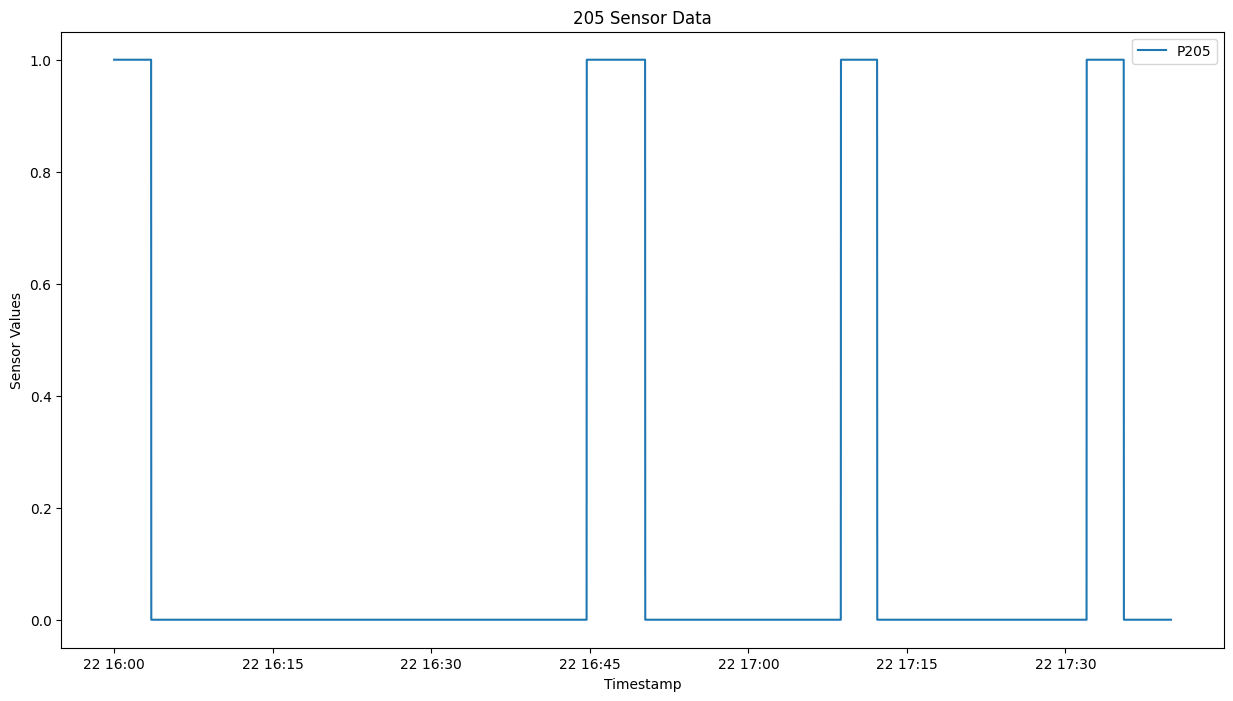

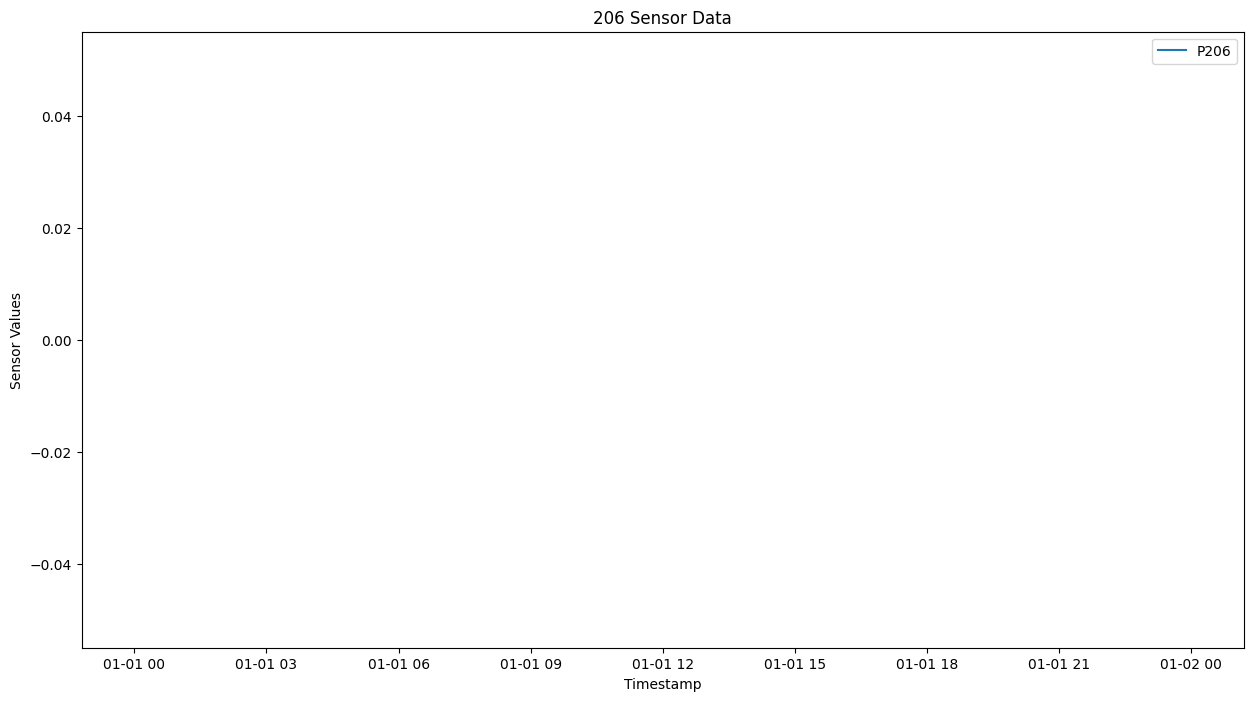

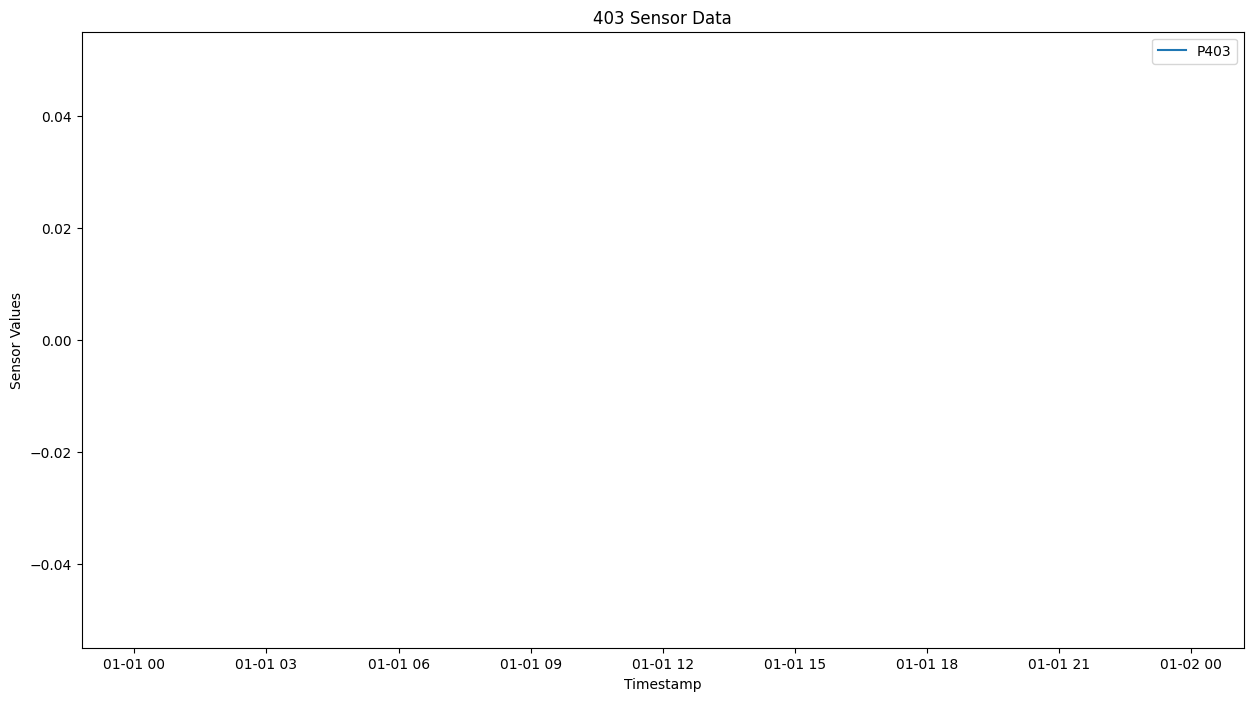

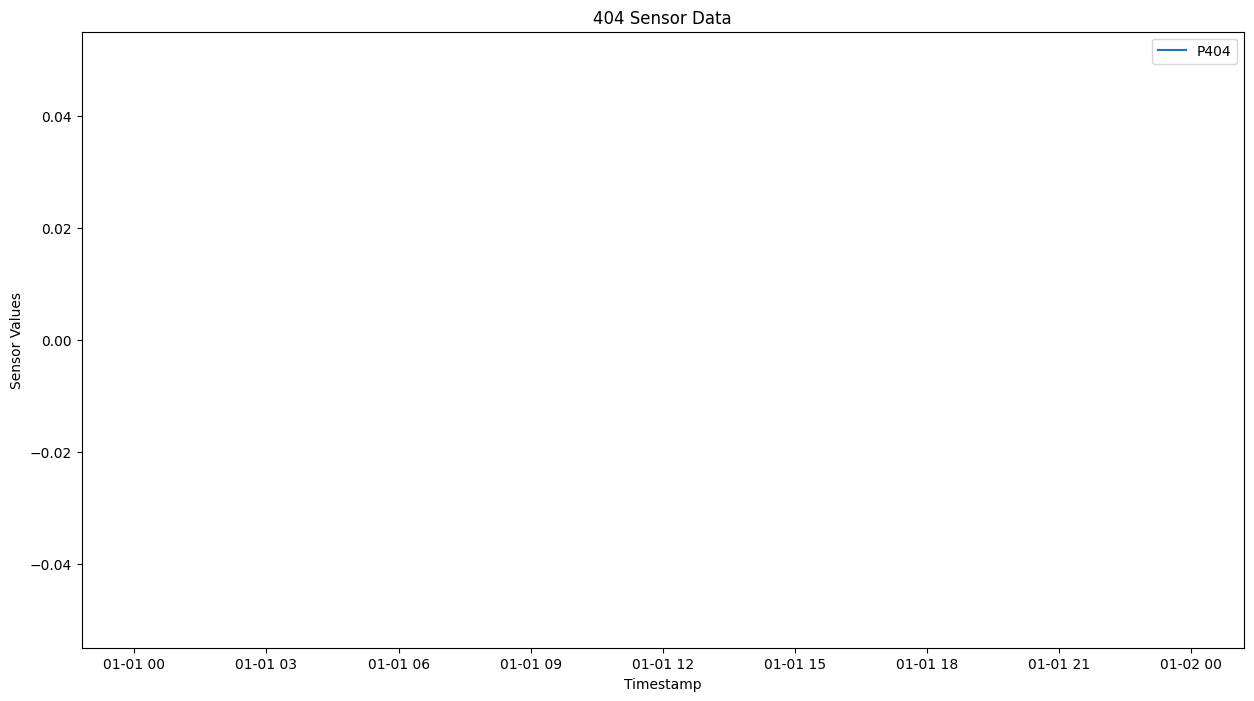

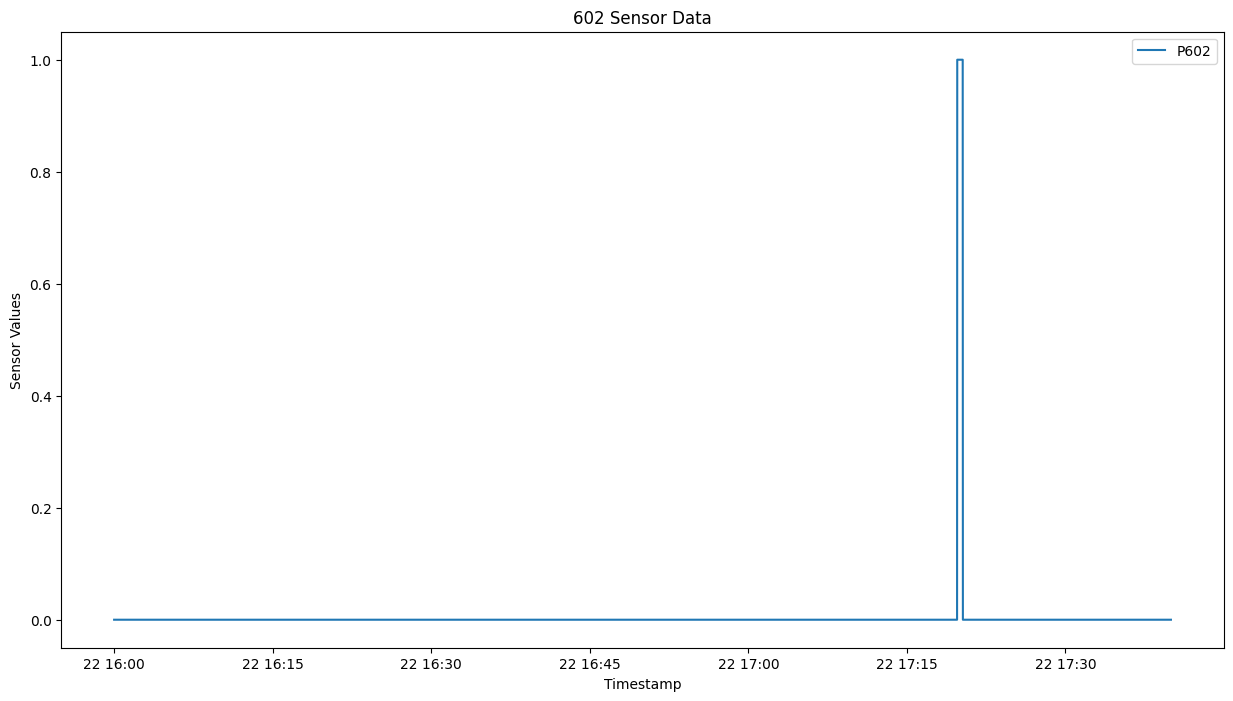

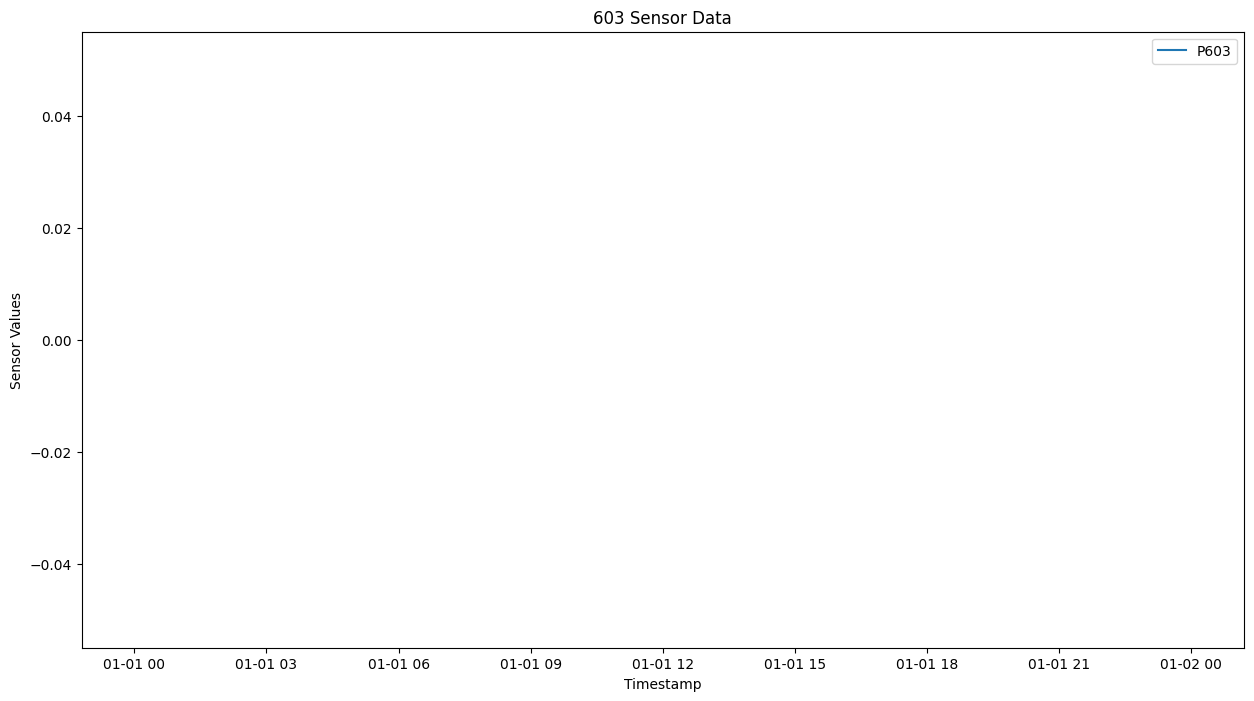

In [11]:
## get sensor numbers
sensors = train_data_num.columns.to_list()

## Group sensors by prefix
sensor_number = [s[-3:] for s in sensors]
sensors_grouped_by_numbers = {p: [] for p in sensor_number}
for s in sensors:
    sensors_grouped_by_numbers[s[-3:]].append(s)

## print sensor name info
print(sensors_grouped_by_numbers)
print(set(sensor_number))

for num, num_sensors in sensors_grouped_by_numbers.items():
    visualize_sensor_data(train_data_norm, window=(0, 6000), sensors=num_sensors, title=f"{num} Sensor Data")


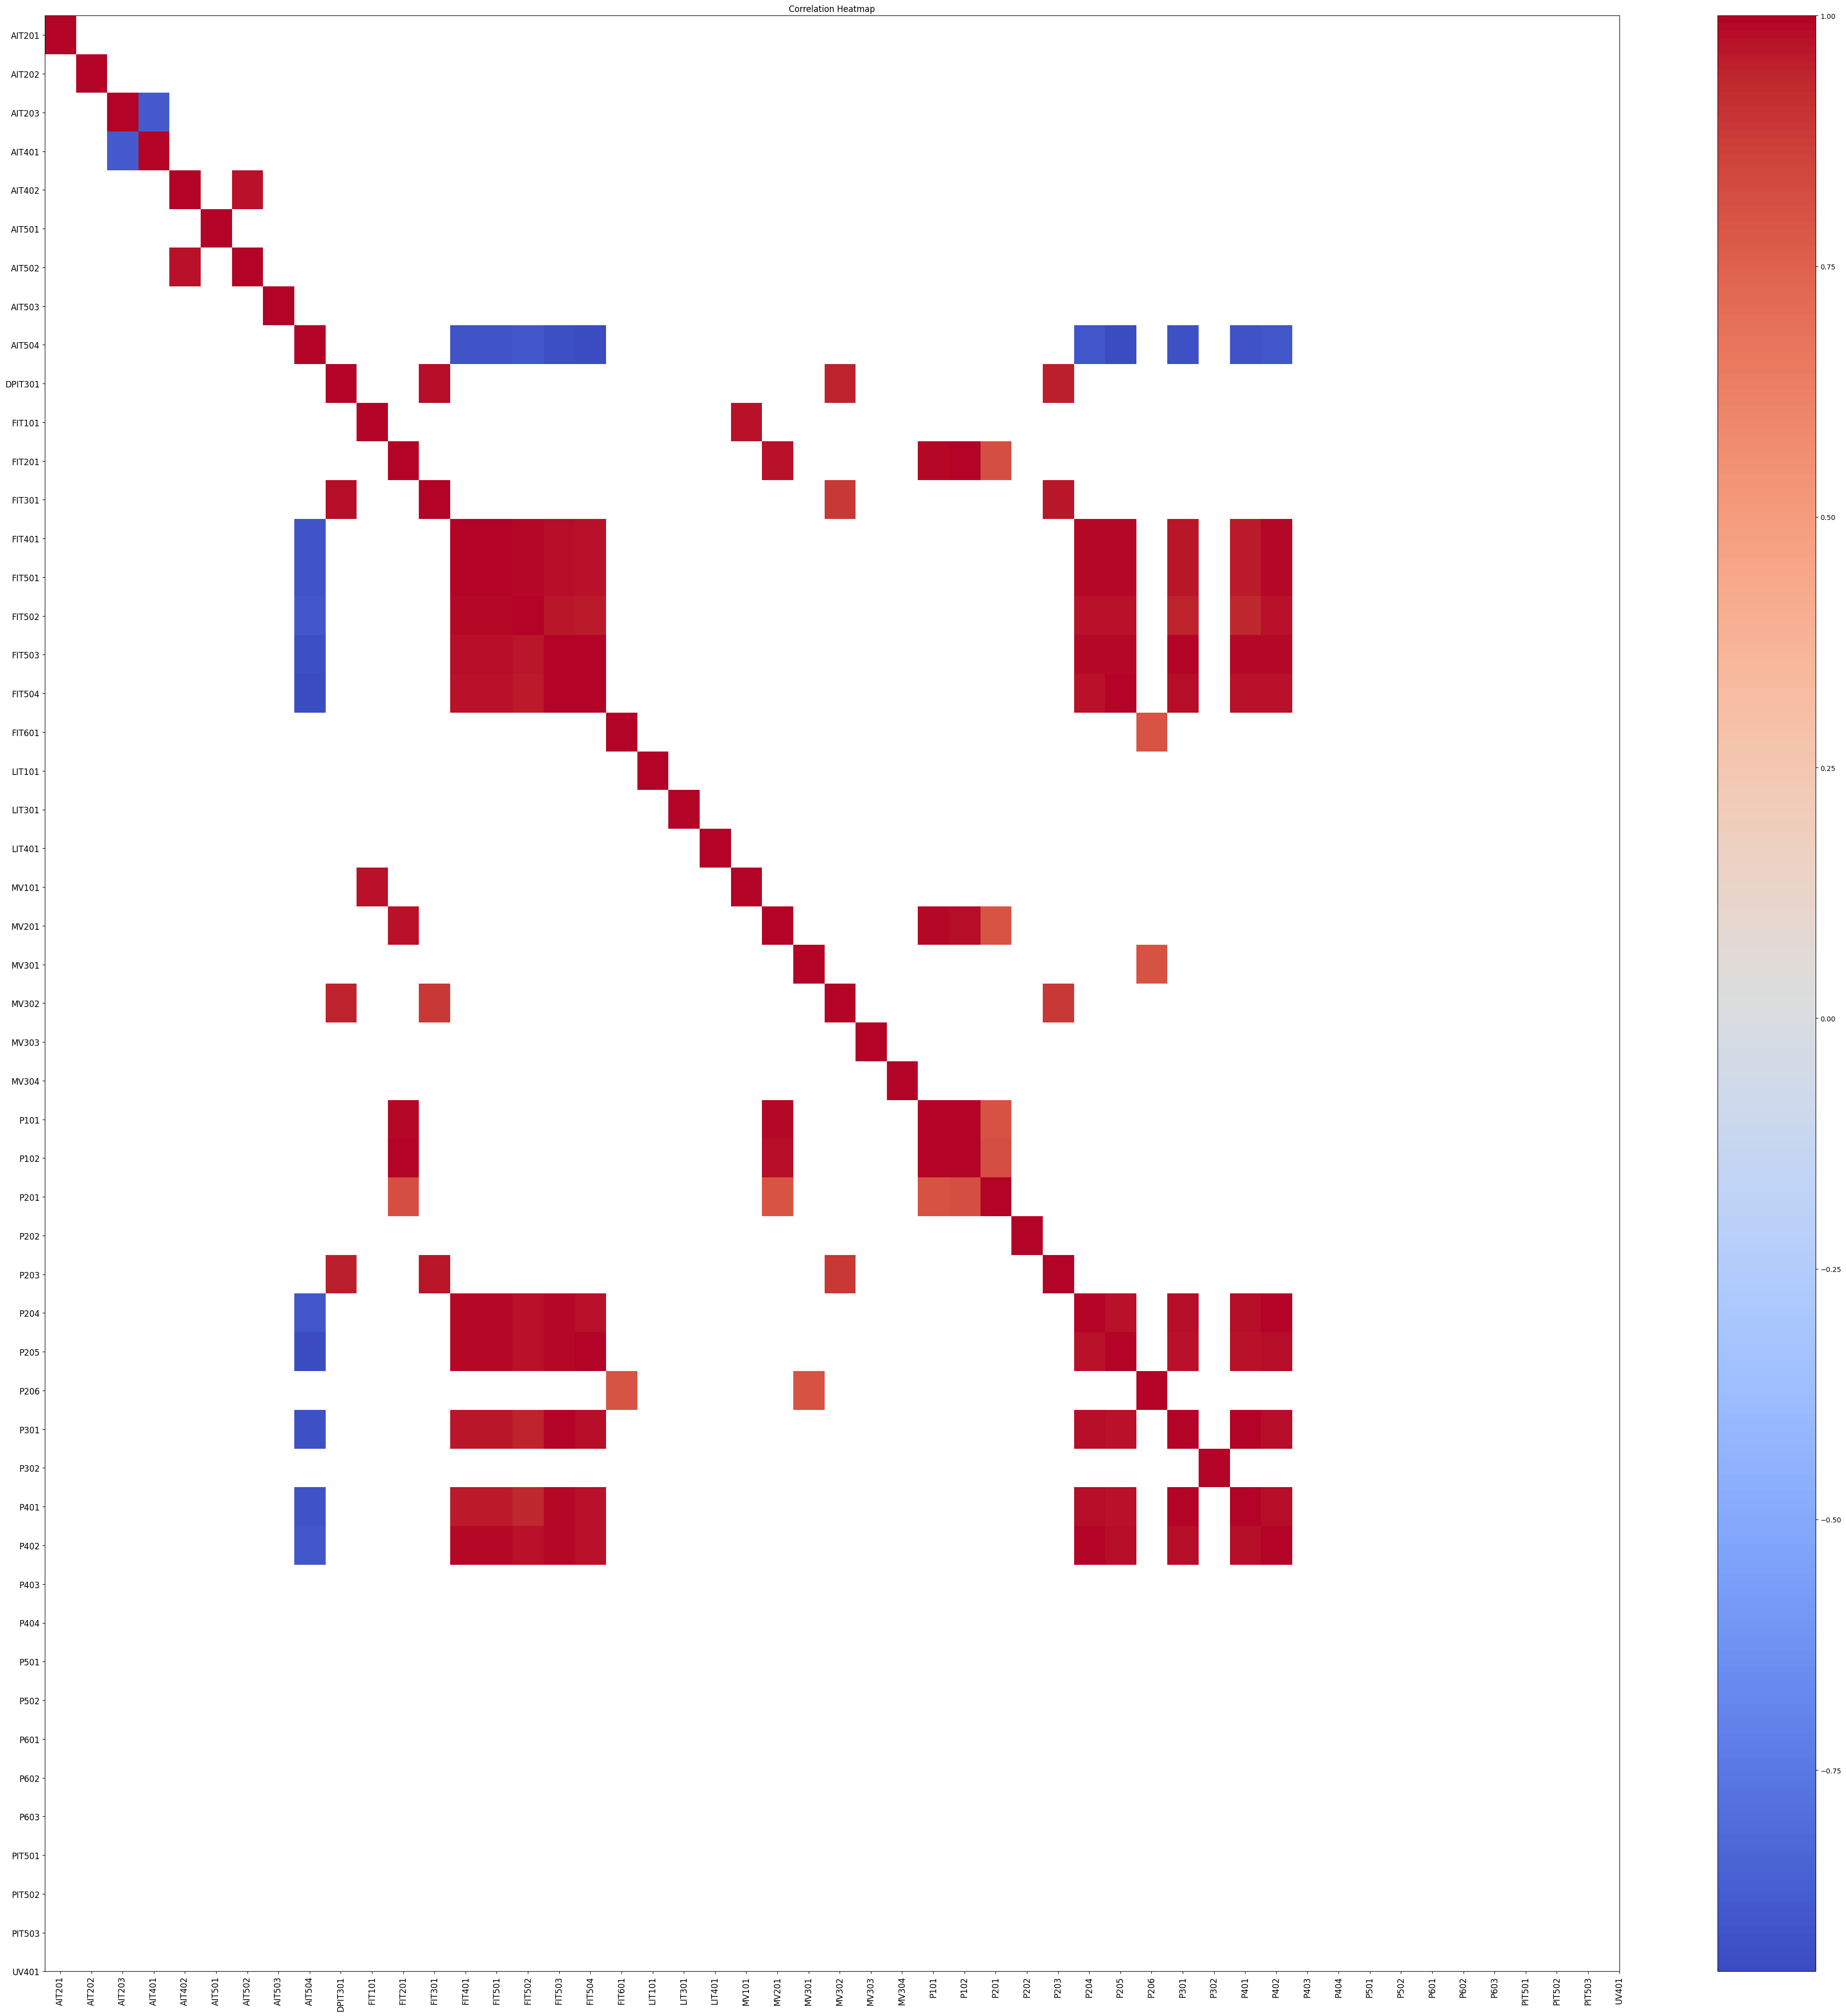

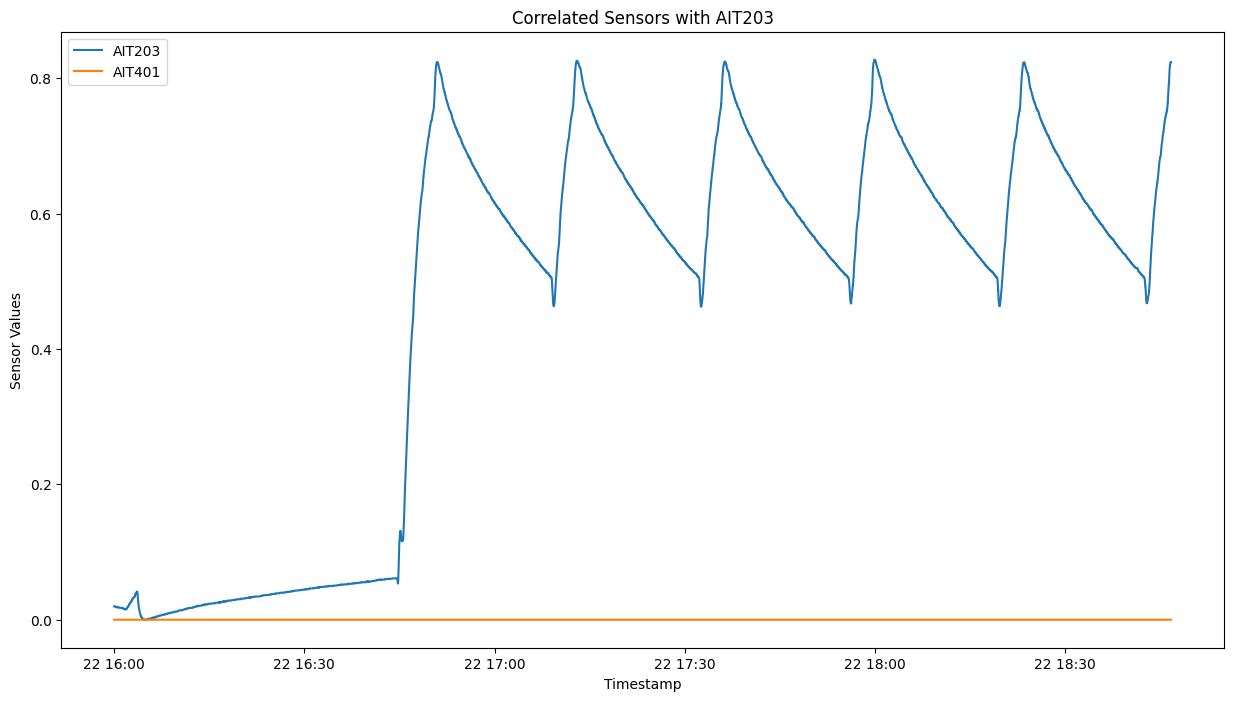

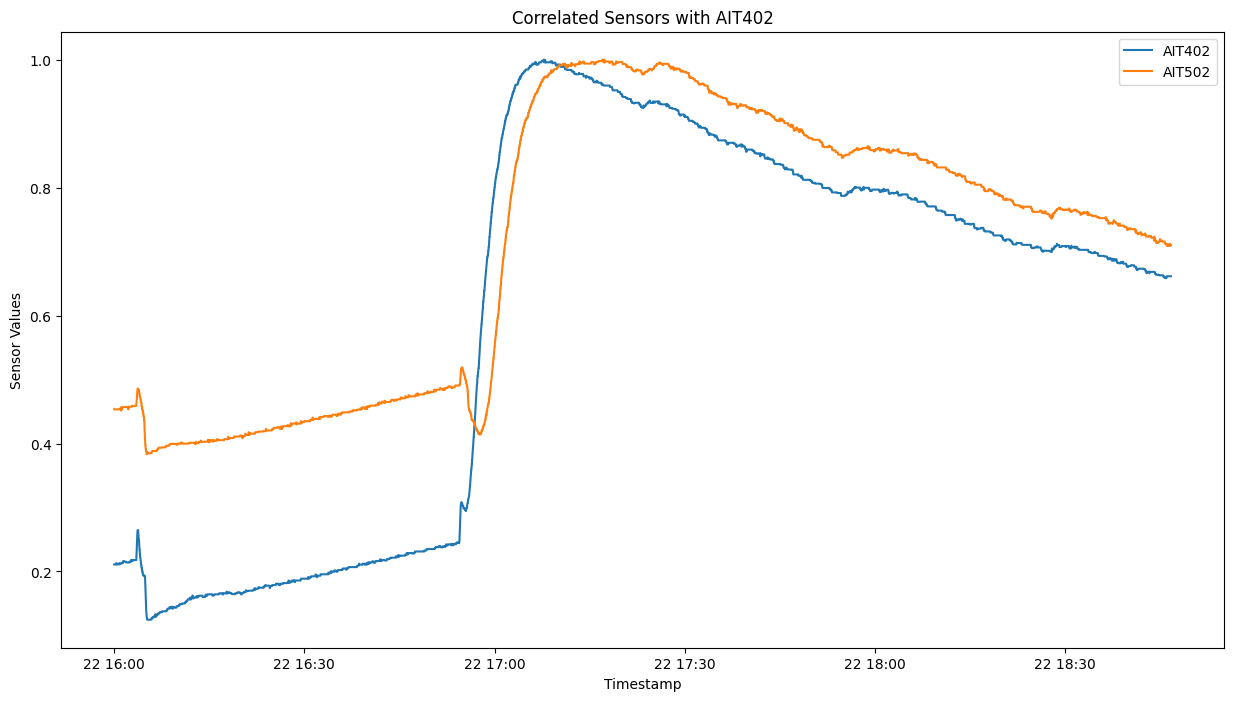

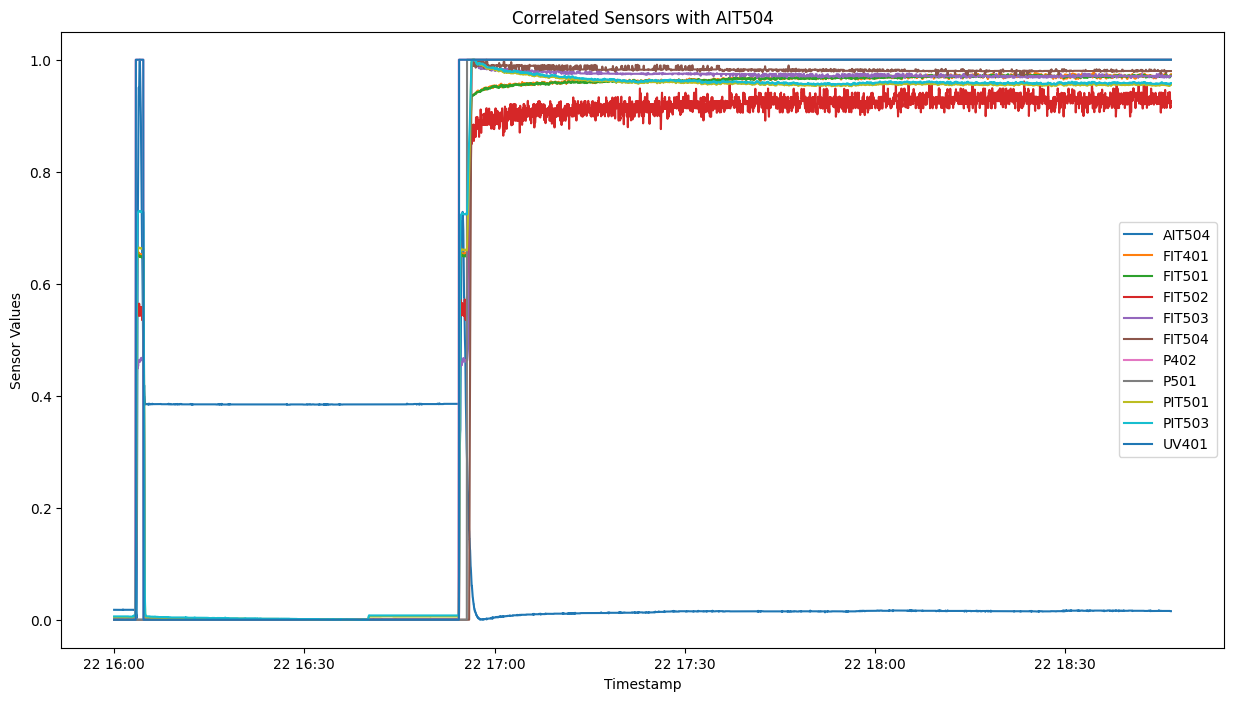

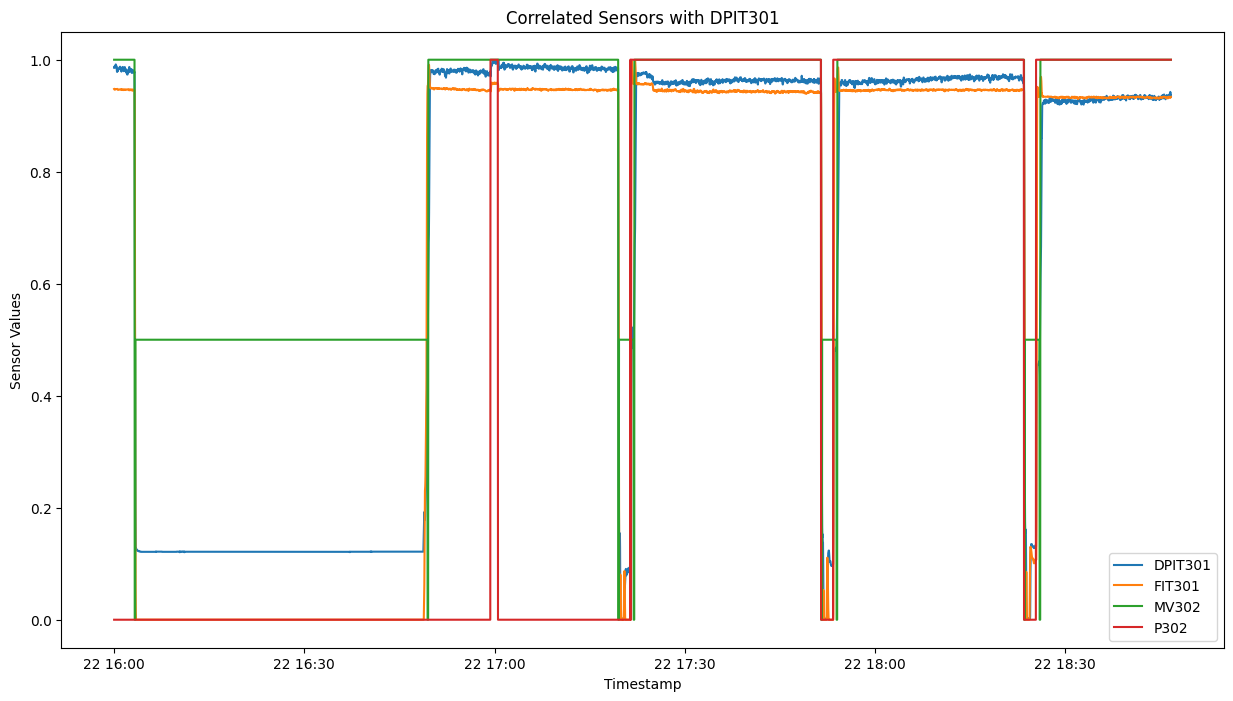

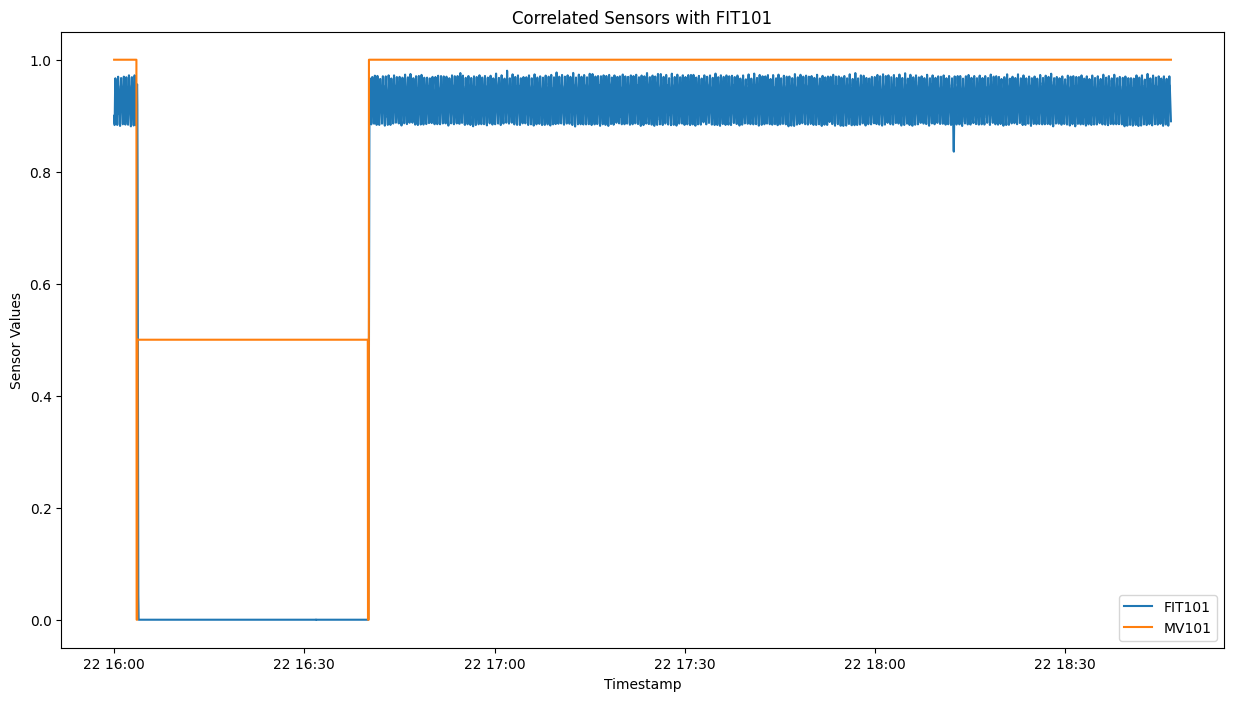

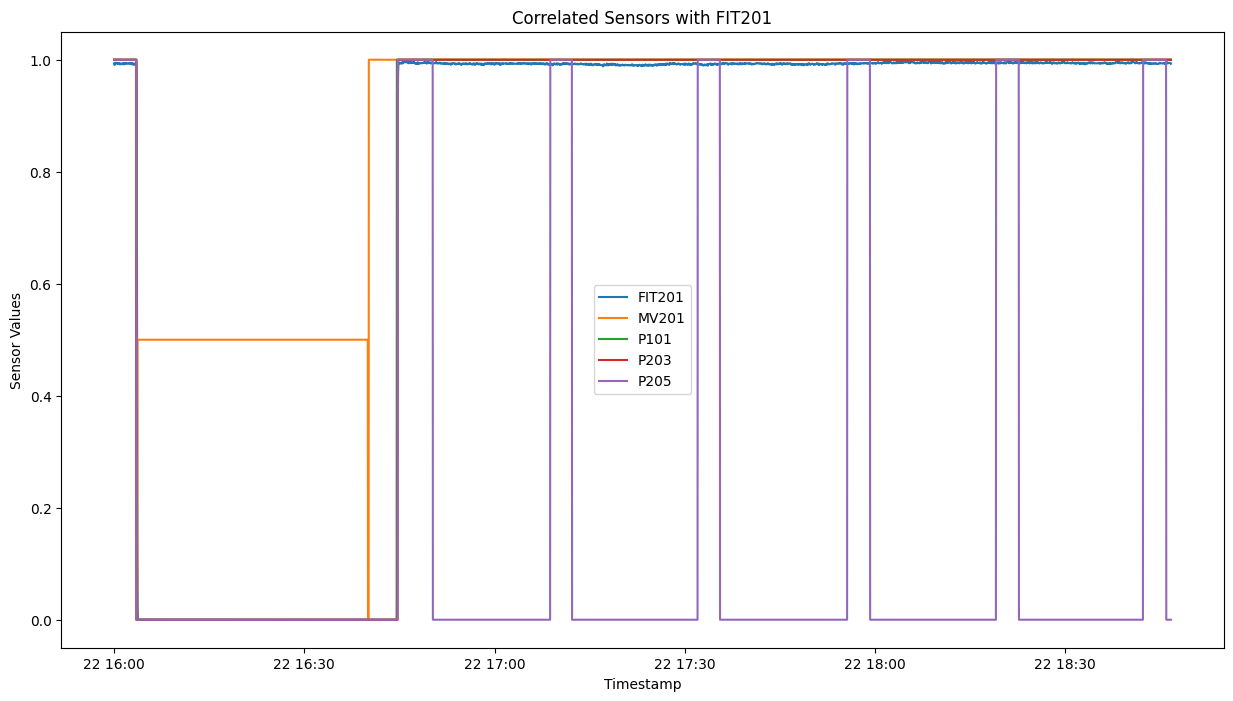

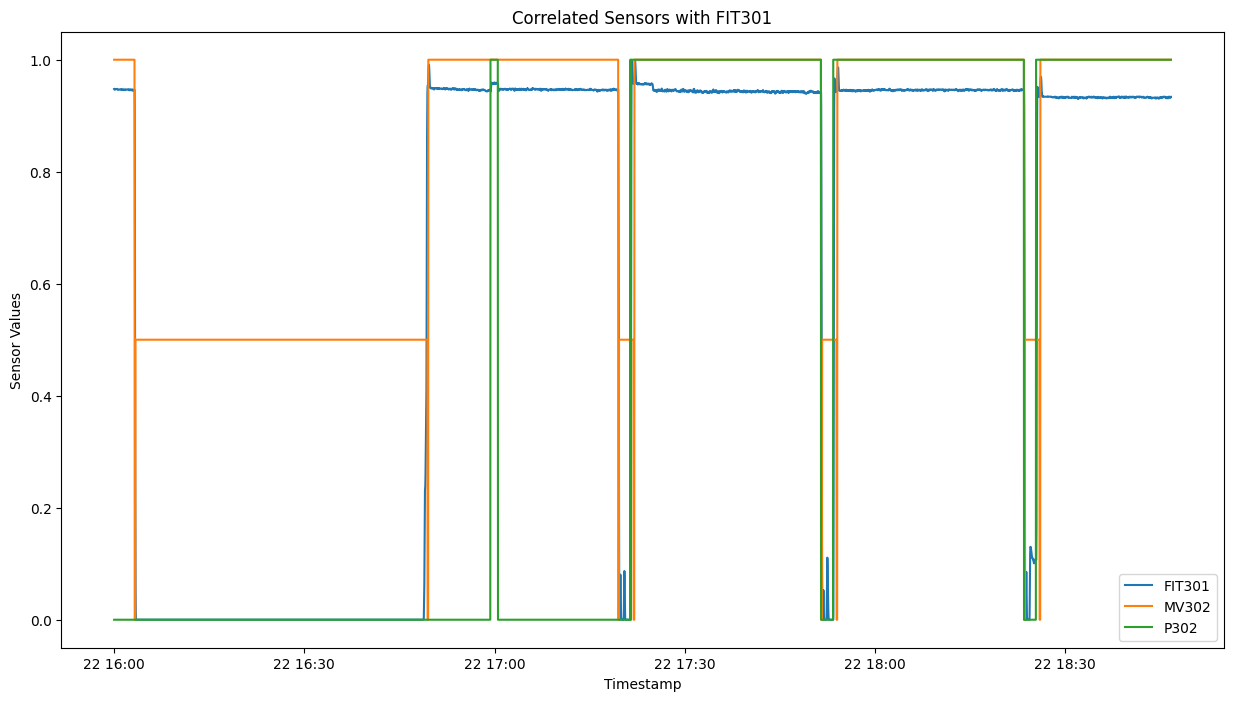

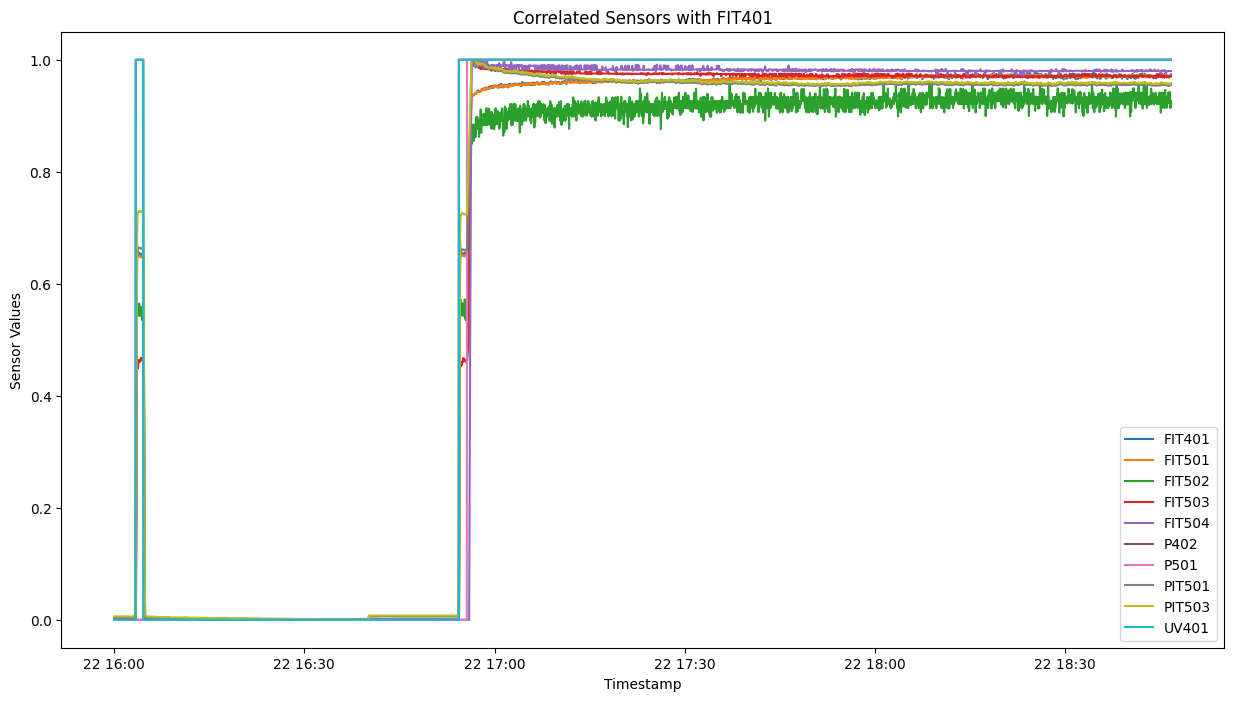

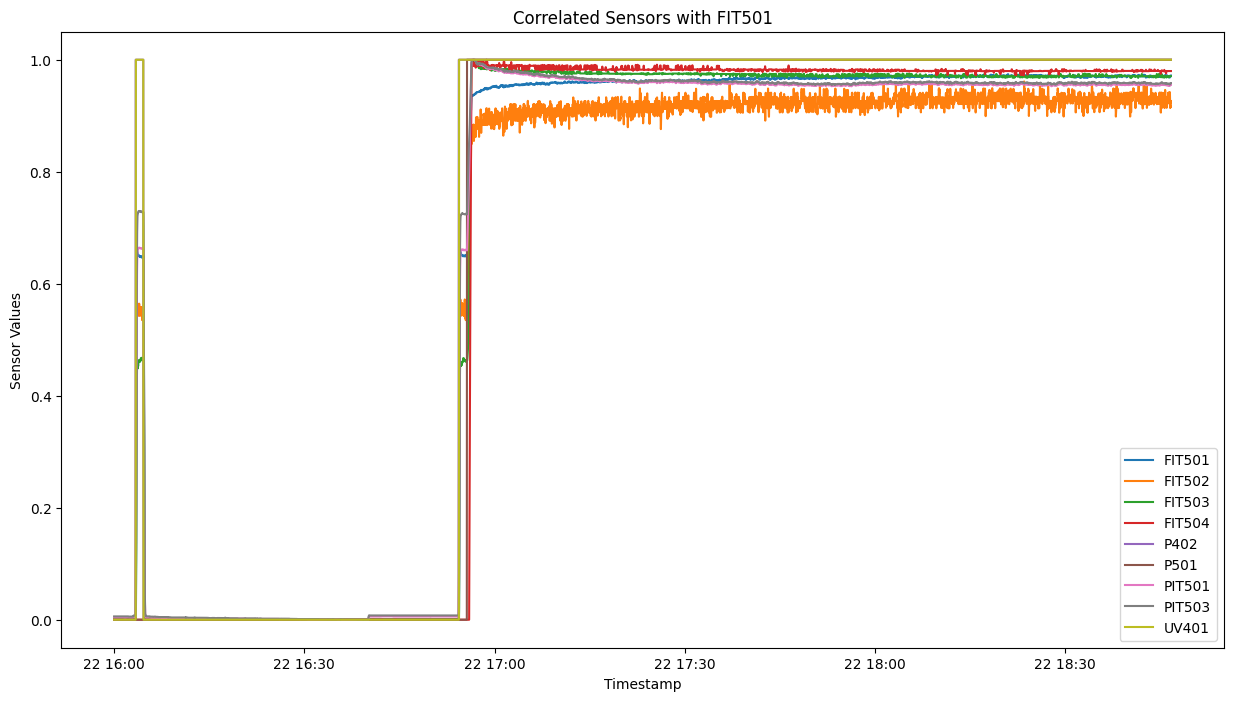

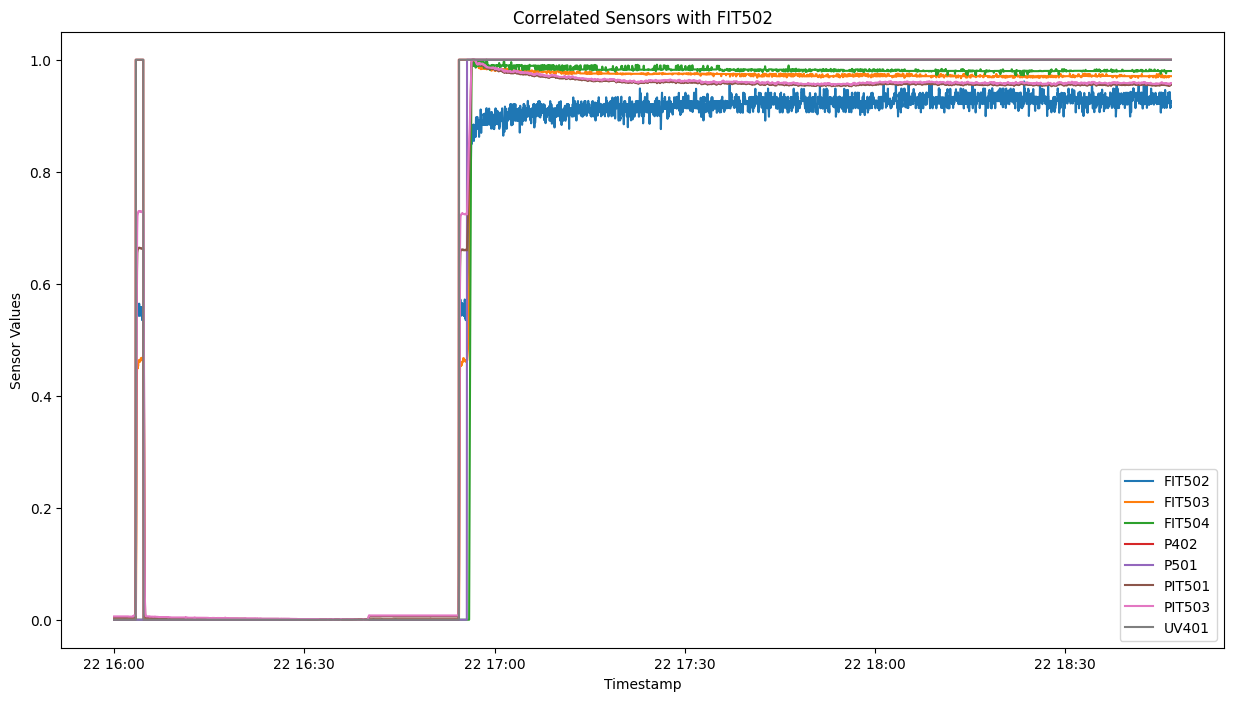

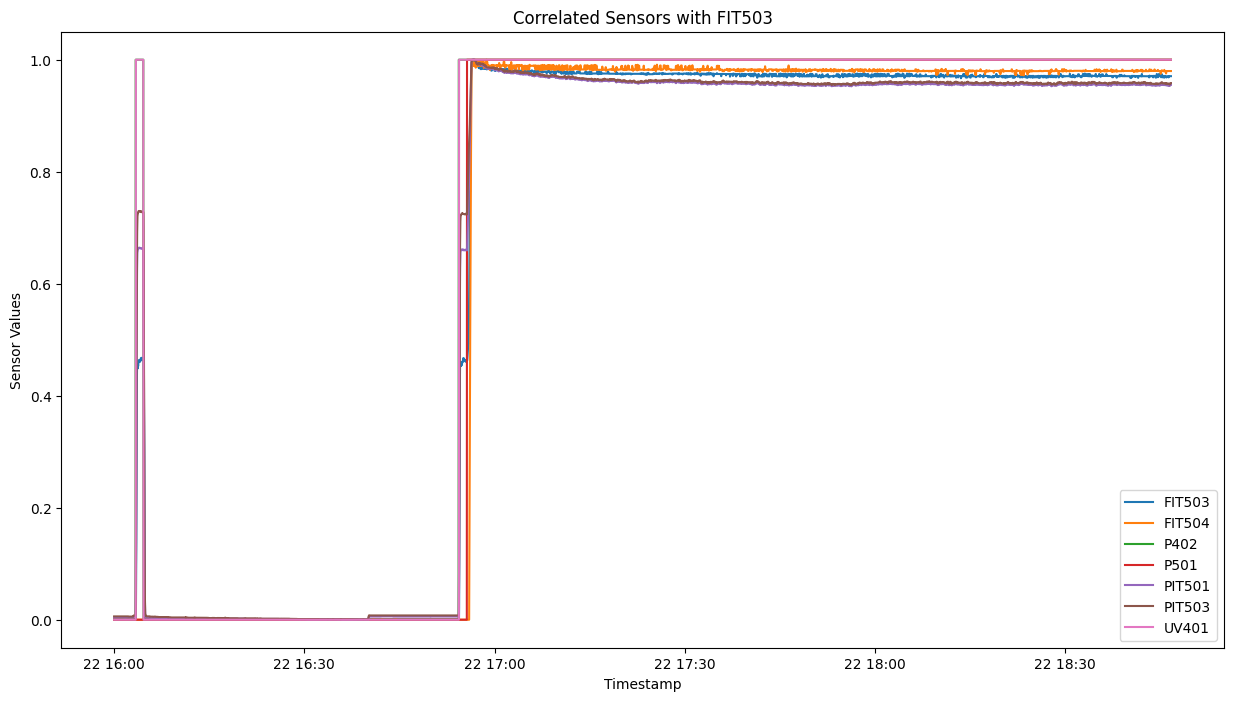

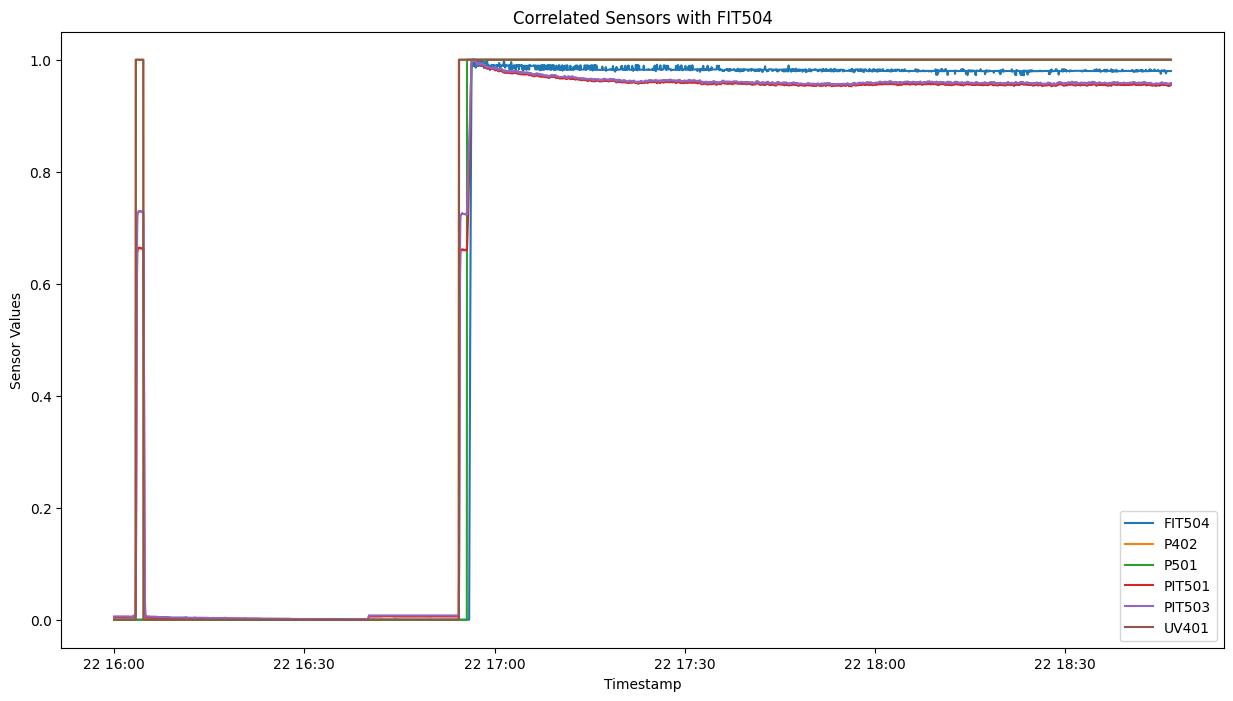

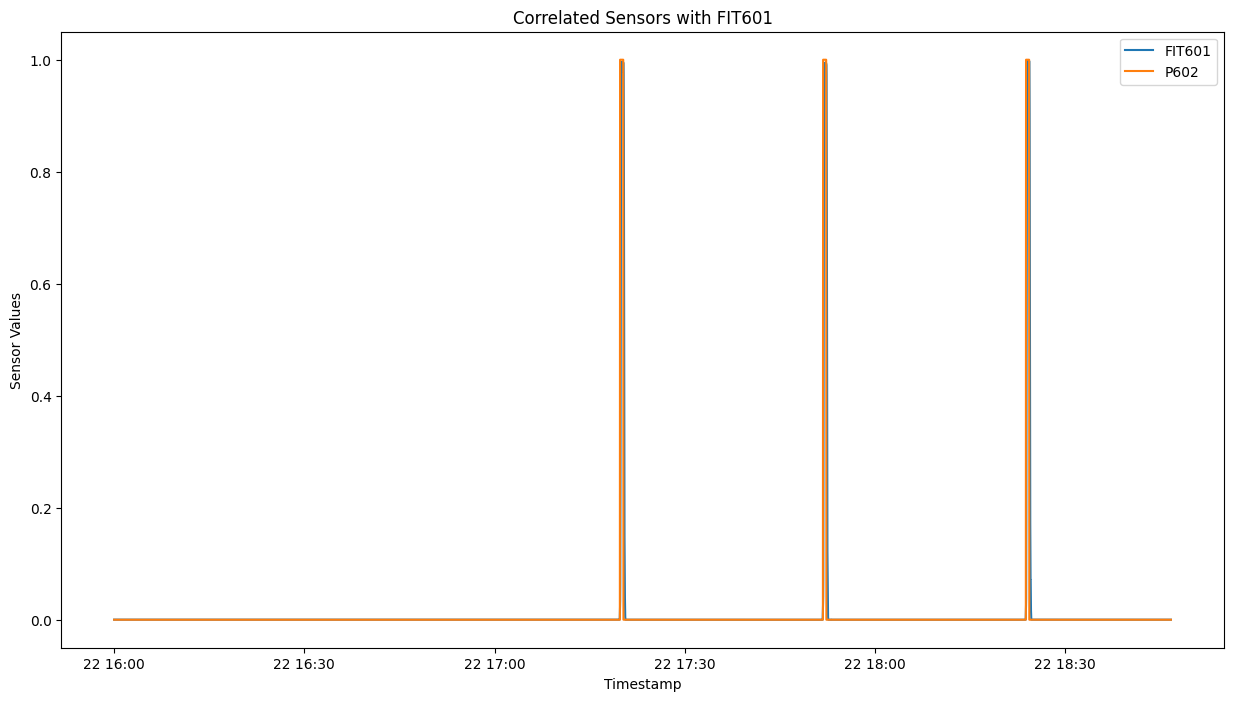

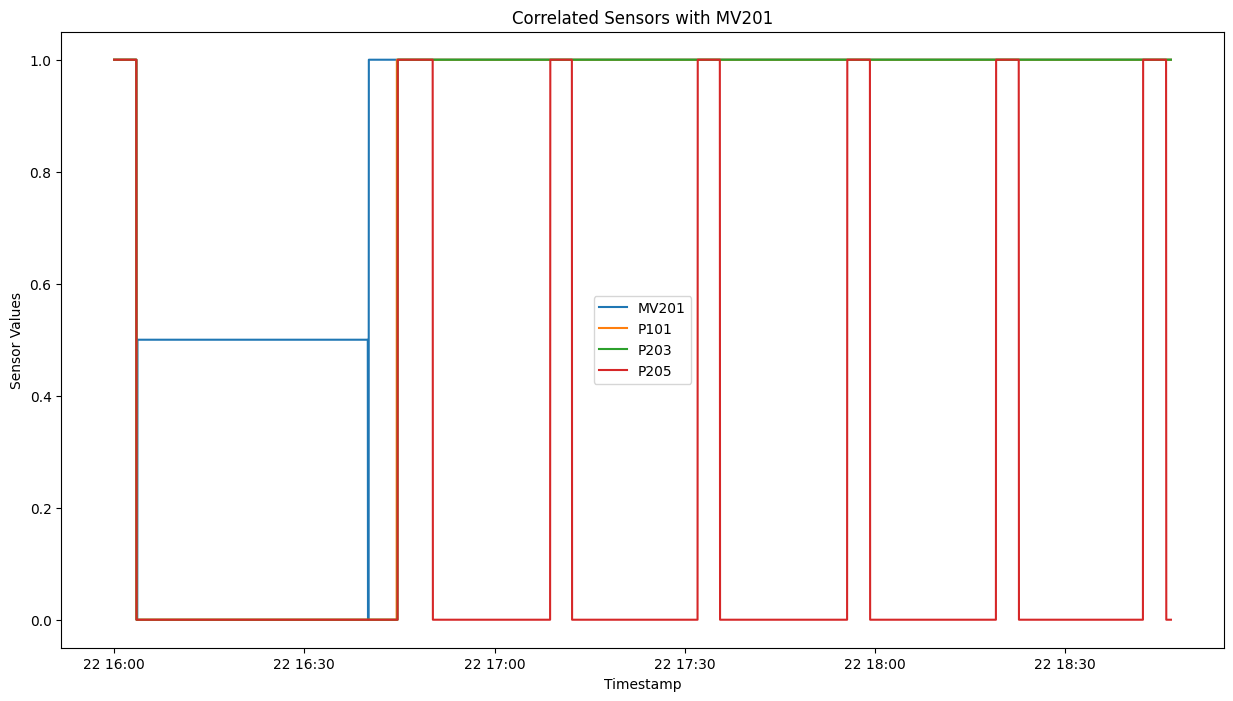

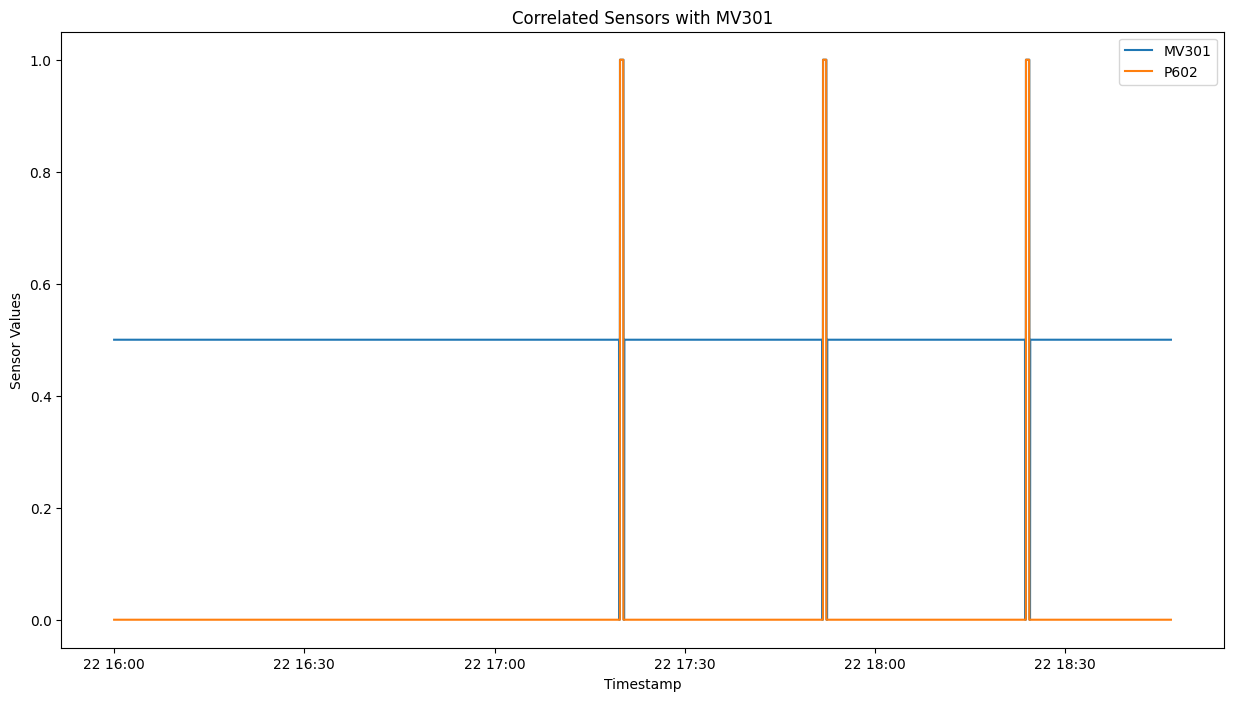

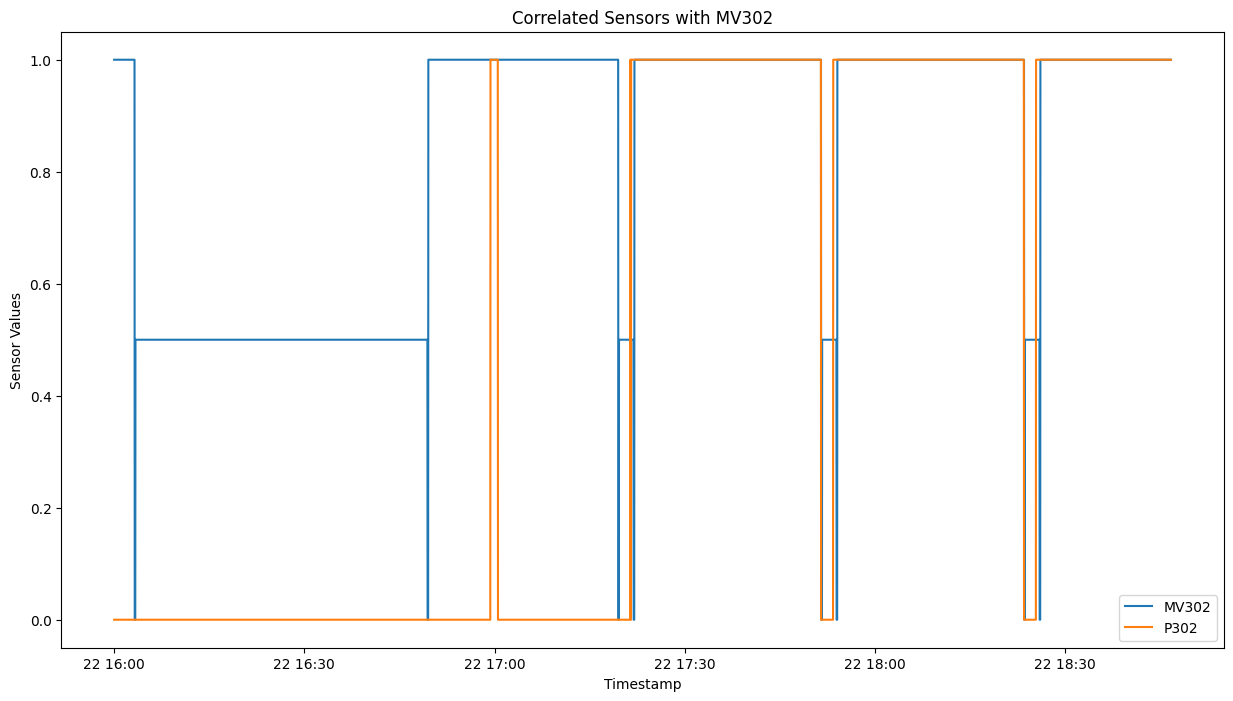

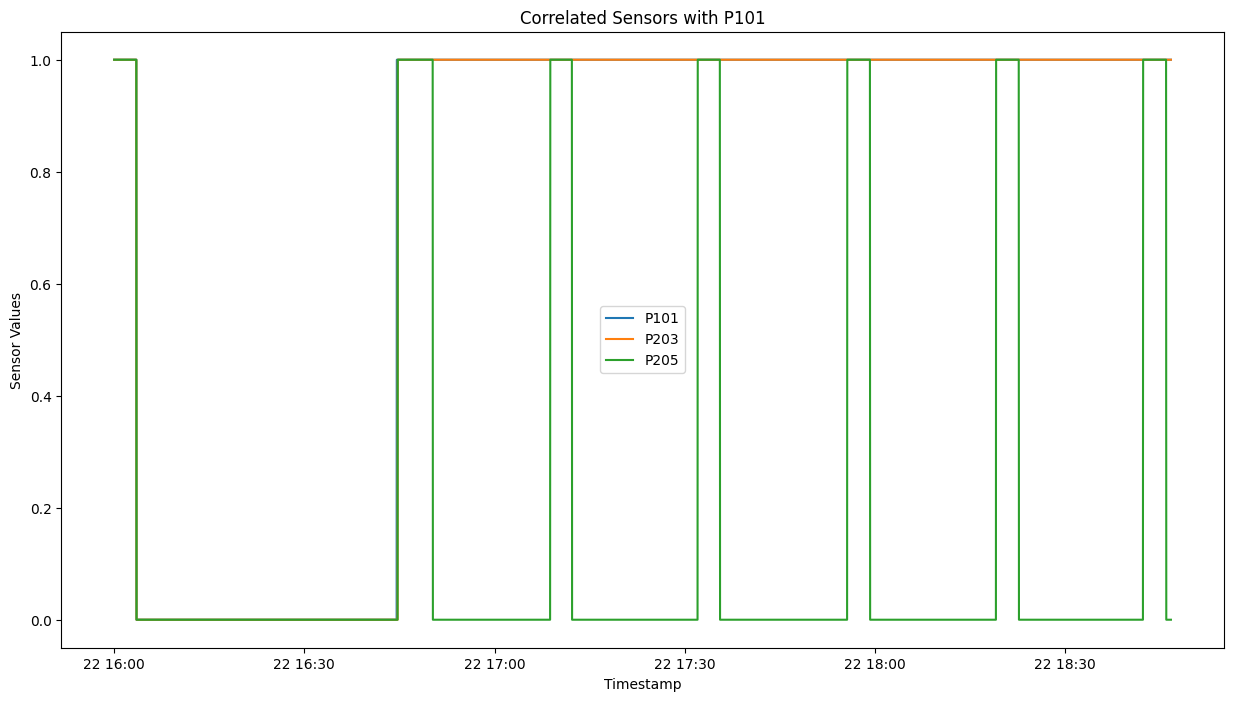

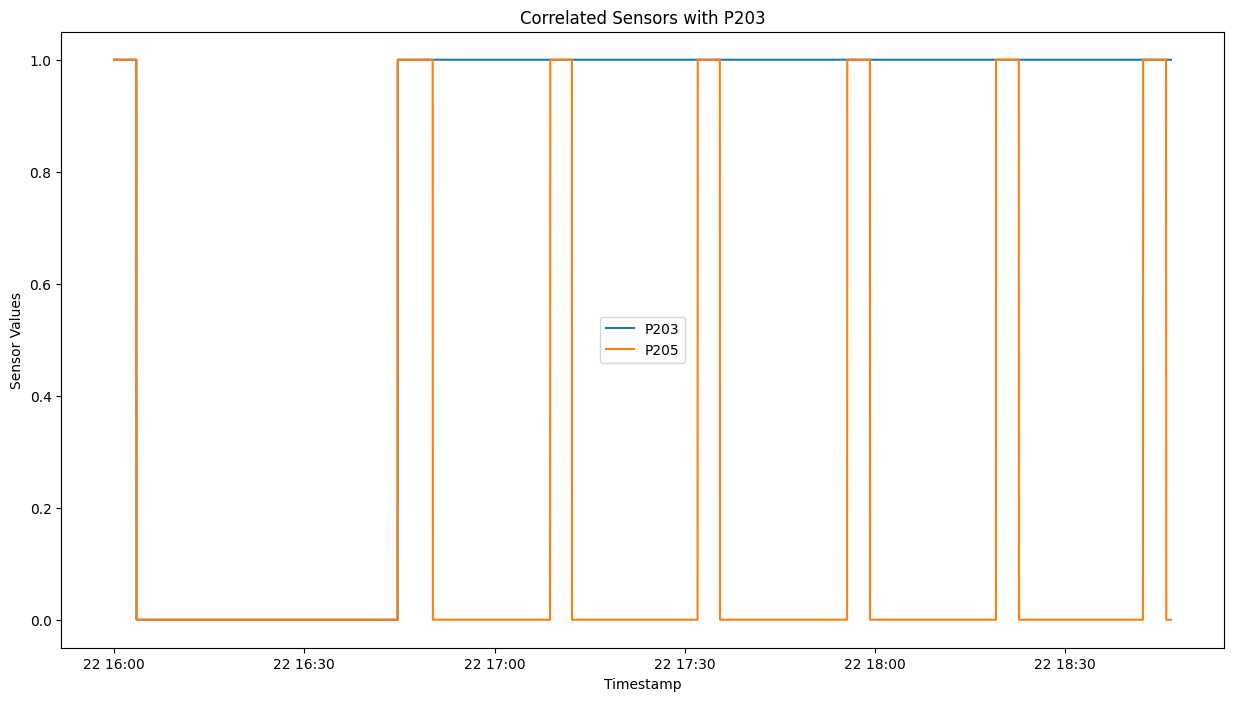

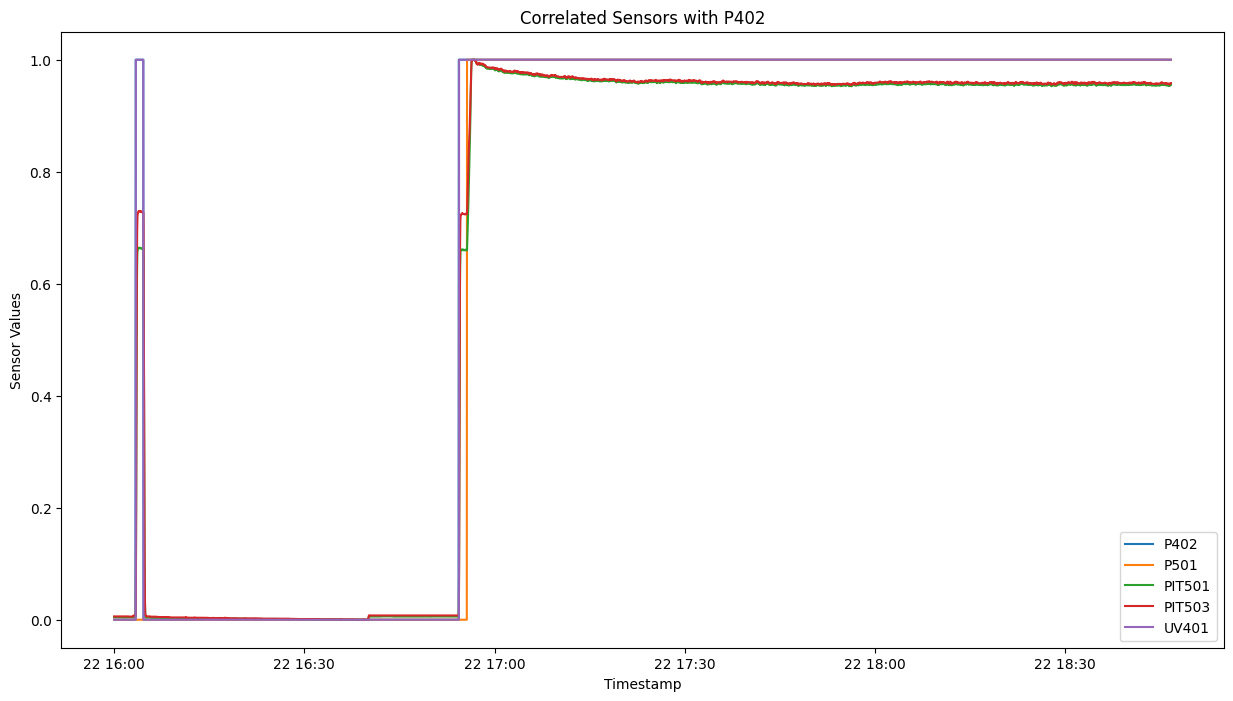

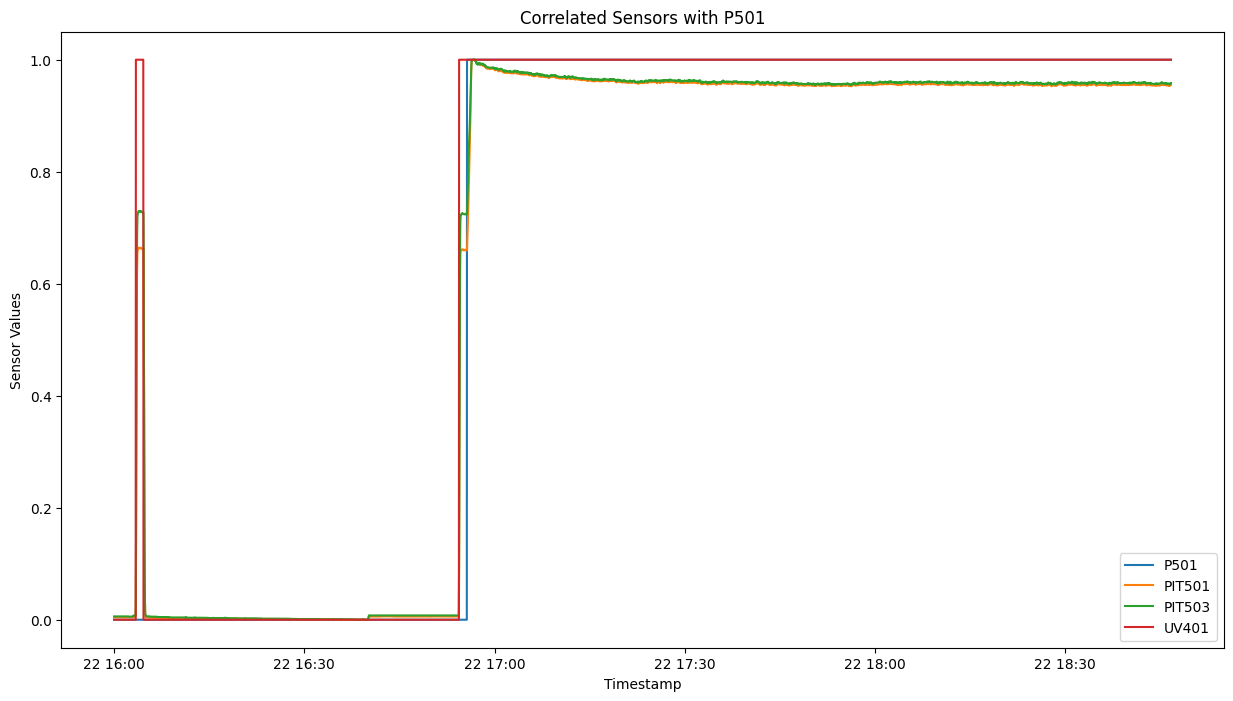

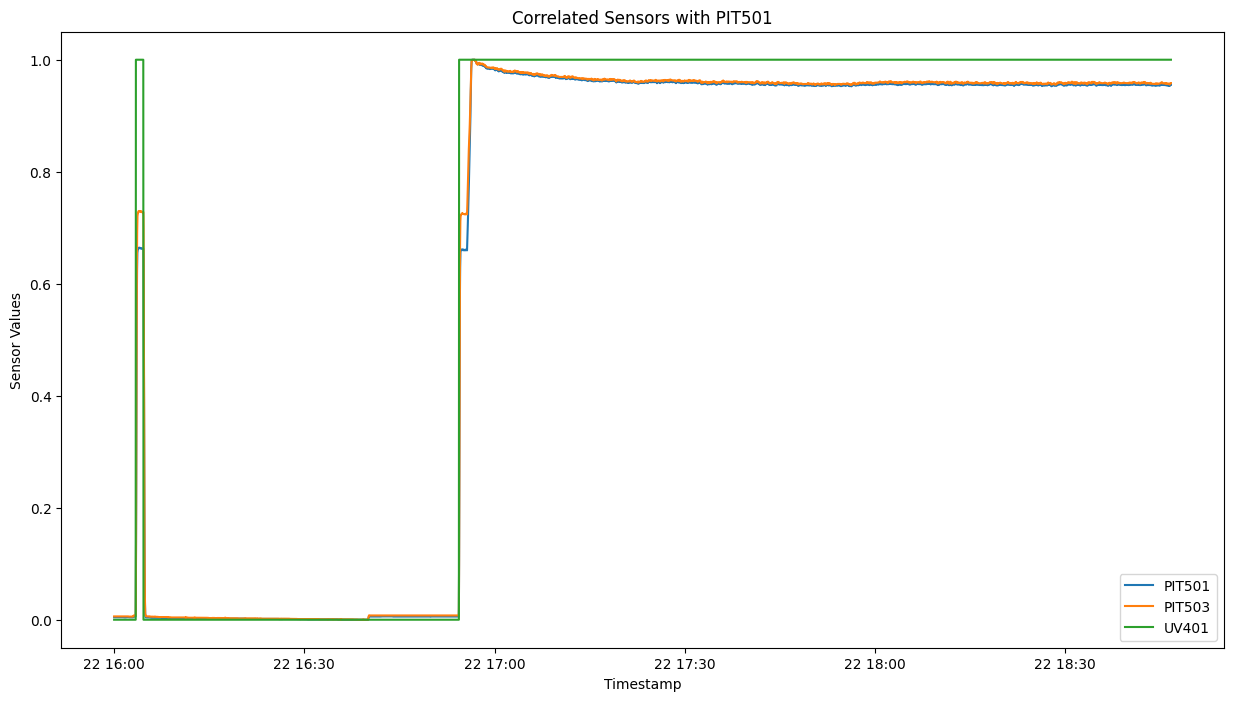

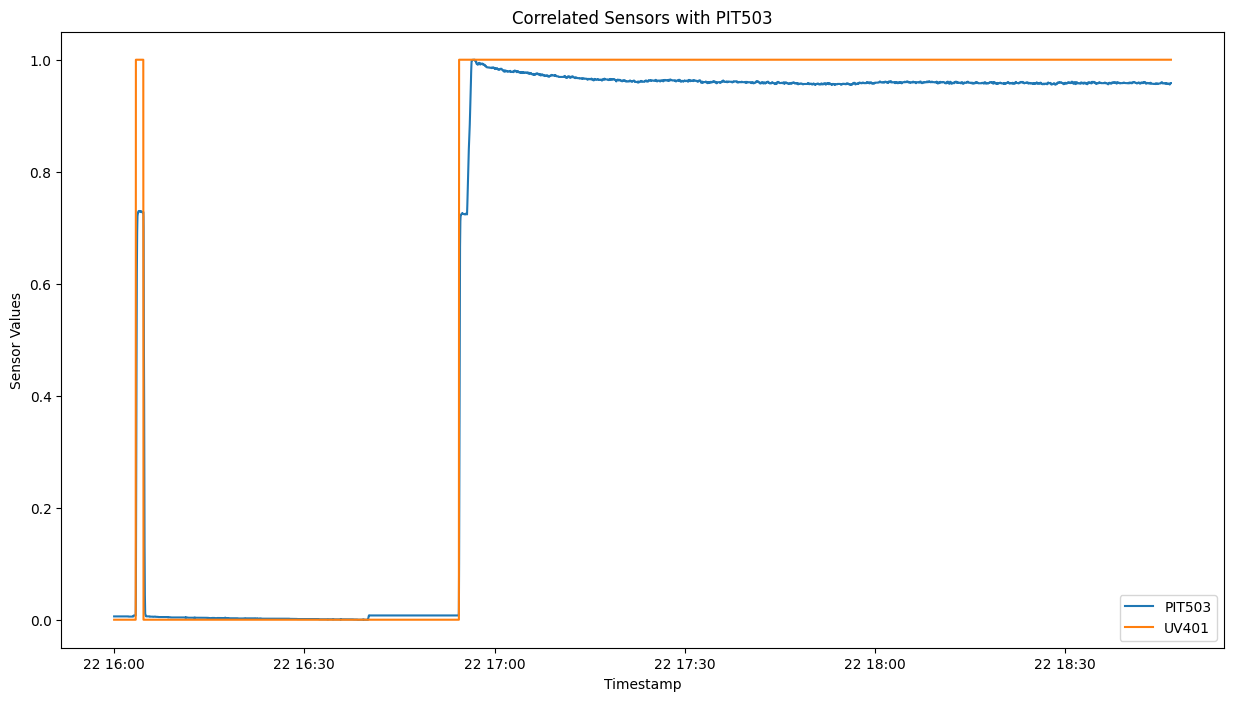

In [12]:
## Correlation analysis
df_corr_anal = train_data_num
cols = df_corr_anal.columns.to_list()

# plot all
plot_correlation_heatmap(df_corr_anal, cols, cols)
correlated_pairs = list_correlations(df_corr_anal, cols, cols)

sensor_groups = {}
for sensor1, sensor2, _ in correlated_pairs:
    if sensor1 not in sensor_groups:
        sensor_groups[sensor1] = [sensor1]  # Include sensor1 itself in the group
    sensor_groups[sensor1].append(sensor2)

# Step 2: Plotting each group
for sensor1, group in sensor_groups.items():
    visualize_sensor_data(df=train_data_norm, window=(0, 10000),sensors=group, title=f'Correlated Sensors with {sensor1}')


In [13]:
for col in train_data.sort_index(axis=1).columns:
    print(f"Sensor: {col}\tvals:{train_data[col].nunique()}\tmin:{train_data[col].min()}\tmax:{train_data[col].max()}")

Sensor: AIT201	vals:549	min:244.3284	max:272.5263
Sensor: AIT202	vals:1695	min:8.19008	max:8.988273
Sensor: AIT203	vals:5696	min:300.8459	max:567.4699
Sensor: AIT401	vals:37	min:0.0	max:148.8561
Sensor: AIT402	vals:2026	min:153.7811	max:235.7088
Sensor: AIT501	vals:843	min:7.303769	max:7.925084
Sensor: AIT502	vals:1987	min:142.3481	max:218.3286
Sensor: AIT503	vals:753	min:252.0828	max:283.3568
Sensor: AIT504	vals:340	min:7.344271	max:309.1899
Sensor: DPIT301	vals:4854	min:0.0	max:21.0993
Sensor: FIT101	vals:2778	min:0.0	max:2.745092
Sensor: FIT201	vals:2879	min:0.0	max:2.487938
Sensor: FIT301	vals:6224	min:0.0	max:2.358774
Sensor: FIT401	vals:710	min:0.0	max:1.747862
Sensor: FIT501	vals:688	min:0.000769034	max:1.757754
Sensor: FIT502	vals:1138	min:0.000640451	max:1.361983
Sensor: FIT503	vals:303	min:0.001024229	max:0.7636911
Sensor: FIT504	vals:203	min:0.0	max:0.3170099
Sensor: FIT601	vals:3533	min:0.0	max:1.746131
Sensor: LIT101	vals:10322	min:120.6237	max:1000.0
Sensor: LIT301	vals:9

#### RESULTS

##### 1. What types of signals are there?
- Inspecting the training data we see that the features are all sensor names, each of these represents a signal. The data is from a SCADA system
- Sensor names have the format (1-4 characters)(3 numbers) f.x FIT101, P201
- Extracting unique prefixes gives:
    {'MV', 'PIT', 'UV', 'LIT', 'FIT', 'DPIT', 'P', 'AIT'}
- In a scada system, this would most likely represent
    1. MV : MOTOR VALVE - valve used to control flow of liquid or gas. Output is status of valve [0,1,2]
    2. PIT : PRESSURE INDICATOR TRANSMITTER - measures pressure of liquid or gas in a system. Output is cont. signal representing pressure [0-1]
    3. UV : ULTRAVIOLET SENSOR - Detects UV light level. Outputs categorical signal [0,1]. Probably represents on/off
    4. LIT : LEVEL INDICATOR TRANSMITTER - Messure level of substance in tank or vessel. Output is cont. signal representing level [0-1]
    5. FIT : FLOW INDICATOR TRANSMITTER - Messure flow rate of a fluid. Output is cont. signal representing flow rate [0-1]
    6. DPIT: DIFFERENTIAL PRESSURE INDICATOR TRANSMITTER - Messures difference in pressure between two points. Output is cont. signal that represents pressure diff. [0-1]
    7. P : Probably valves? - We think this represents valves being open/closed. Output is categorical [0,1] and many PXXX have no values.
    8. AIT : ANALYTICAL INDICATOR TRANSMITTER - Used to analyse particular charecteristic of substance (f.x pH, conductivity, etc). All outputs are continious, represent the charecteristic being messuared, and range from [0-1].



##### 2. Are the signals correlated? Do they show cyclic behaviour?

From our correlation analysis we see that many of the signals are highly correlated.
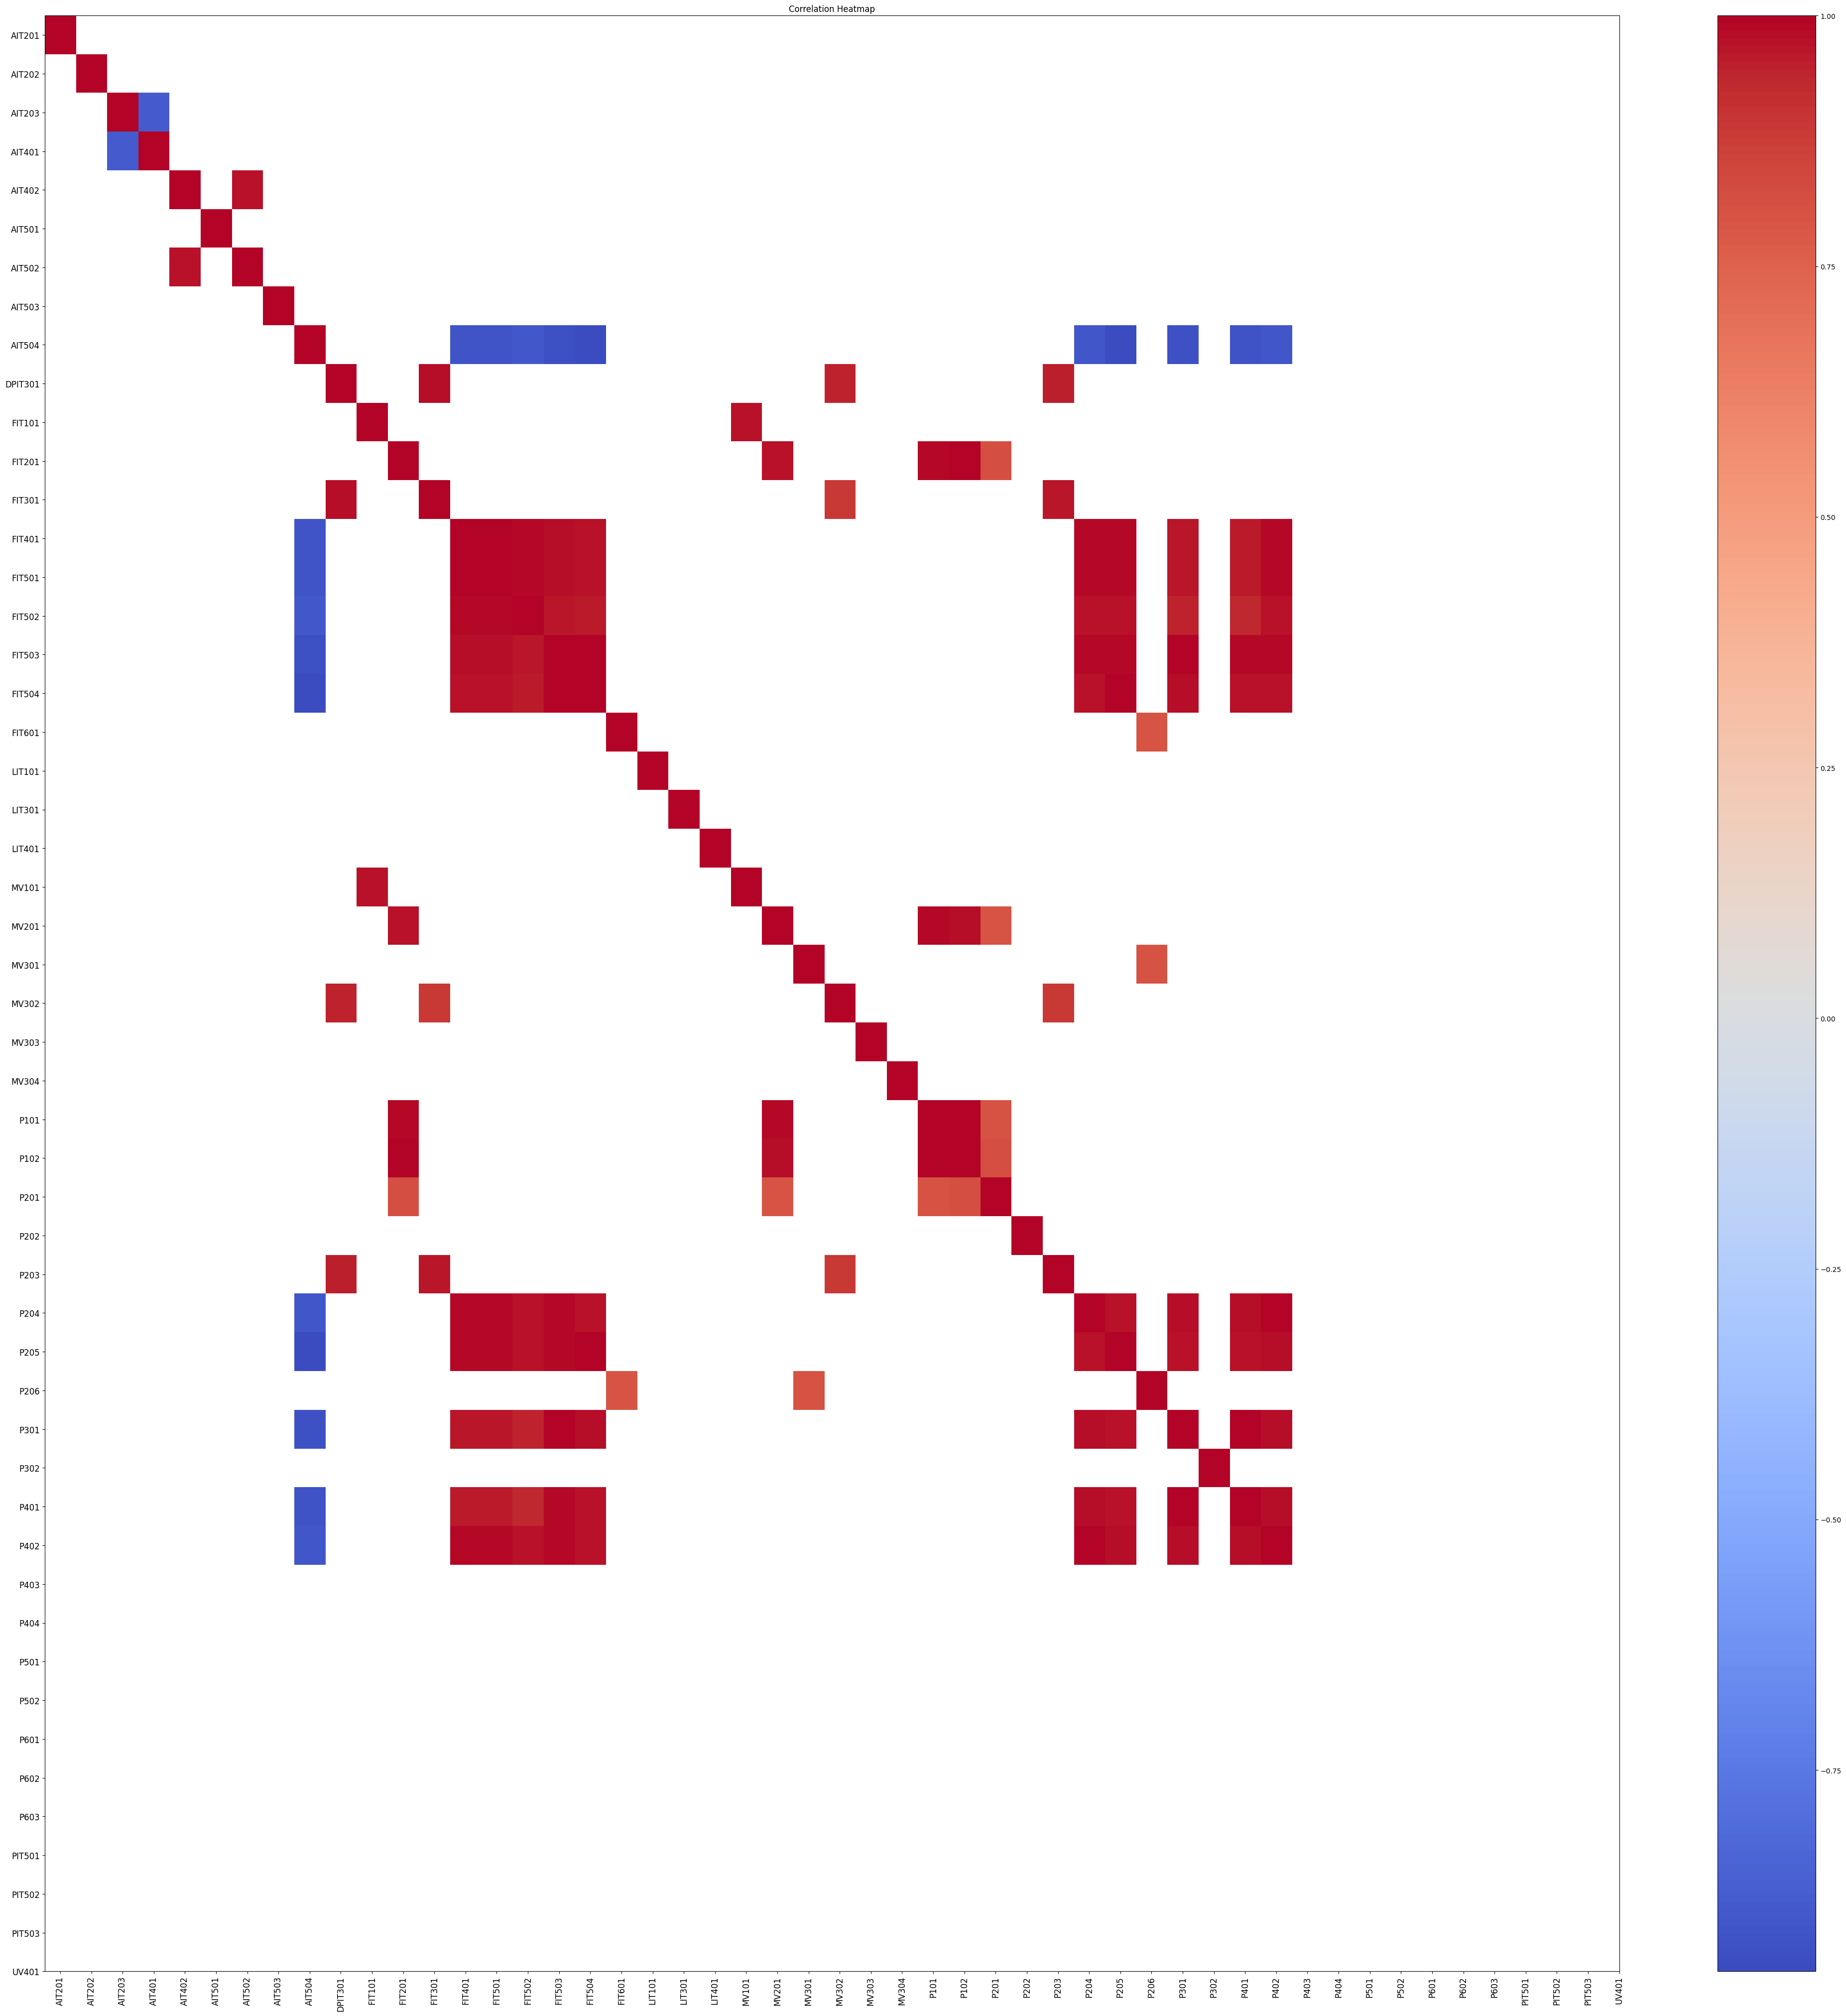 

And from the graphs, we also notice cyclic behaviour

### DTW

#### Concept and Implementation

The idea behind using Dynamic Time Warping (DTW) for anomaly detection in this exercise is to measure the similarity between temporal sequences. DTW is particularly effective for time-series data, where sequences may vary in speed but have the same overall pattern. The goal is to identify anomalies in SCADA systems by finding data points whose distance to the nearest training data point exceeds a certain threshold.

#### Data Preparation

To begin, the data from the "LIT401" sensor is downsampled by a factor of 100 for computational efficiency. This downsampled data is then used to create a set of representative sliding windows. The windows are formed using a defined WINDOW_SIZE and STEP_SIZE, ensuring that each window captures a meaningful segment of the data. These windows serve as a reference for comparing other data points or windows.

In [14]:
#gettin some number of windows to compare to
WINDOW_SIZE = 100
STEP_SIZE = 100
DTW_K_VALUE = 15

train_data_array = np.array(train_data["LIT401"][::100])

sliding_windows_represent = np.lib.stride_tricks.sliding_window_view(train_data_array, window_shape=WINDOW_SIZE)[::STEP_SIZE, :]

print(f"number of windows to compare to {len(sliding_windows_represent)}")

#getting windows from train set to figure out the threshold
STEP_SIZE = 50

sliding_windows = np.lib.stride_tricks.sliding_window_view(train_data_array, window_shape=WINDOW_SIZE)[::STEP_SIZE, :]

THRESHOLD_DTW = 0 

for i in range(10, len(sliding_windows)):
    
    window1 = sliding_windows[i]
    min_distance = MAX_FLOAT
    for window2 in sliding_windows_represent:
        distance = dynamic_time_warping_optimized(window1, window2, DTW_K_VALUE)
        #the 500 is here becaouse sometimes i return max_float and I don't think that is okay
        if(distance < min_distance):
            min_distance = distance
    
    if(min_distance > THRESHOLD_DTW ) :
        THRESHOLD_DTW = min_distance
        print(f"curent threshold {THRESHOLD_DTW}")
    print(f"{i}/{len(sliding_windows)}")

print(f"final threshold {THRESHOLD_DTW}")    

number of windows to compare to 49
10/98
curent threshold 46.94027048622538
11/98
12/98
curent threshold 61.53471740903667
13/98
14/98
15/98
16/98
17/98
18/98
19/98
20/98
21/98
22/98
23/98
24/98
25/98


KeyboardInterrupt: 

####  Anomaly Detection

For anomaly detection in the test dataset, the same WINDOW_SIZE and STEP_SIZE are used to create sliding windows. Each window from the test set is compared against the representative windows from the training set. If the minimum DTW distance between a test window and all representative windows exceeds the threshold, an anomaly is detected. This process helps identify windows in the test data that significantly deviate from the normal pattern observed in the training data.

In [ ]:
#getting windows from test set 
WINDOW_SIZE = 100
STEP_SIZE = 50

test_data_array = np.array(test_data["LIT401"][::100])

sliding_windows = np.lib.stride_tricks.sliding_window_view(test_data_array, window_shape=WINDOW_SIZE)[::STEP_SIZE, :]

counter = 0

THRESHOLD_DTW = 80 #adjuested from a method above

print(f" curretnt threshold {THRESHOLD_DTW}")

anomalies_dtw = []

for i in range(len(sliding_windows)):
    
    window1 = sliding_windows[i]
    min_distance = MAX_FLOAT
    for window2 in sliding_windows_represent:
        distance = dynamic_time_warping_optimized(window1, window2, DTW_K_VALUE)
    
        if(distance < min_distance):
            min_distance = distance

    if(min_distance > THRESHOLD_DTW):
        counter += 1
        print(f"Detected Anomaly at {i} with distance {min_distance}")

        start_index = max(0, i  * STEP_SIZE)
        end_index = max(0, start_index + WINDOW_SIZE)

        anomalies_dtw.append((start_index, end_index))

        #visualize_sensor_data(test_data[::100], window=(start_index, end_index)  , sensors=['LIT401'], title='LIT401 Sensor Test Data Visualization')
        
    print(f"{i}/{len(sliding_windows)}")

print(f" {counter} ")


####  Visualization

Finally, the detected anomalies are visualized on the downsampled sensor data. Each anomaly is highlighted using a red window on the plot, providing a clear visual representation of where the anomalies occur in the time series. The timestamps corresponding to the start and end of each anomalous window are adjusted to align with the downsampled data.

In [ ]:
# Create a downsampled DataFrame
downsampled_data = test_data[::100]

# Plotting the downsampled dataset
plt.figure(figsize=(15, 8))
plt.plot(downsampled_data['Timestamp'], downsampled_data['LIT401'], label='LIT401', color='blue')

# Highlighting anomalies
for start_index, end_index in anomalies_dtw:
    start_index += 50
    end_index += 50
    # Fetching the corresponding timestamps from the downsampled dataset
    if start_index < len(downsampled_data) and end_index < len(downsampled_data):
        start_timestamp = downsampled_data['Timestamp'].iloc[start_index]
        end_timestamp = downsampled_data['Timestamp'].iloc[end_index]

        # Highlighting the anomaly window
        plt.axvspan(start_timestamp , end_timestamp, color='red', alpha=0.3)

plt.xlabel('Timestamp')
plt.ylabel('Sensor Values')
plt.title('LIT401 Sensor Test Data Visualization (Downsampled)')
plt.legend()
plt.show()

#### Residuals Analysis

To further analyze the DTW-based anomaly detection, the residuals (minimum DTW distances) for both the train and test data are plotted. This plot provides insights into the distribution of DTW distances and helps in visually identifying any significant deviations that correspond to anomalies. The threshold is also plotted as a horizontal line, making it easier to see which data points are classified as anomalies.

In [ ]:
residuals_dtw_train = []
sliding_windows = np.lib.stride_tricks.sliding_window_view(train_data_array, window_shape=WINDOW_SIZE)[::STEP_SIZE, :]

for i in range(len(sliding_windows)):
    
    window1 = sliding_windows[i]
    min_distance = MAX_FLOAT
    for window2 in sliding_windows_represent:
        distance = dynamic_time_warping_optimized(window1, window2, DTW_K_VALUE)
    
        if(distance < min_distance):
            min_distance = distance

    
    residuals_dtw_train.append((min_distance))

print(f" {counter} ")

plt.figure(figsize=(15, 8))
plt.plot(pd.DataFrame(residuals_dtw_train), label='train')

sliding_windows = np.lib.stride_tricks.sliding_window_view(test_data_array, window_shape=WINDOW_SIZE)[::STEP_SIZE, :]
residuals_dtw_test = []

for i in range(len(sliding_windows)):
    
    window1 = sliding_windows[i]
    min_distance = MAX_FLOAT
    for window2 in sliding_windows_represent:
        distance = dynamic_time_warping_optimized(window1, window2, DTW_K_VALUE)
    
        if(distance < min_distance):
            min_distance = distance


    residuals_dtw_test.append((min_distance))

       

print(f" {counter} ")

plt.plot(pd.DataFrame(residuals_dtw_test), label='test')

plt.axhline(y = THRESHOLD_DTW, color = "red", alpha = 0.7)

plt.xlabel('Timestamp')
plt.ylabel('Residual Values')
plt.title('LIT401 Sensor DTW residuals (Downsampled)')
plt.legend()
plt.show()

### PCA

#### METHODS

In [ ]:
def compute_explained_variance(eigenvalues: np.ndarray):
    return np.cumsum(eigenvalues / eigenvalues.sum())

In [ ]:
class PCAPipe():

    def __init__(self, df: pd.DataFrame, k: int, normalize) -> None:
        if not callable(normalize):
            raise TypeError("Normalize needs to be callable")
        
        self.normalize = normalize;
        
        df_norm, deNorm = self.normalize(df)
        
        cov_mat = df_norm.cov().values;

        # Find eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

        # Find k PC's (largest eigenvalues)
        PCA_indices = np.argsort(eigenvalues)[-k:][::-1] 
        eigenvectors = eigenvectors[:,PCA_indices]

        # Set K and eigenvalues
        self.K = eigenvectors
        self.eigenvalues = eigenvalues[PCA_indices]


    def recomputePCA(self, df: pd.DataFrame, k: int):
        
        df_norm, deNorm = self.normalize(df)
        
        cov_mat = df_norm.cov().values;

        # Find eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(cov_mat)

        # Find k PC's (largest eigenvalues)
        PCA_indices = np.argsort(eigenvalues)[-k:][::-1] 
        eigenvectors = eigenvectors[:,PCA_indices]

        # Set K and eigenvalues
        self.K = eigenvectors
        self.eigenvalues = eigenvalues[PCA_indices]
        return self

    def PCA_anomaly_detection(self, df:pd.DataFrame, dist):
        if not callable(dist):
            raise TypeError("dist must be a callable function")

        
        df_norm, deNorm = self.normalize(df)
        mean_array = deNorm[0].values.reshape(1, -1)
        
        # project
        Y = df_norm.values @ self.K

        # Compute explained variance
        self.explained_variance = compute_explained_variance(self.eigenvalues)

        # reconstruct and denormalize
        X_norm = (Y @ self.K.transpose())
        if (deNorm[2] == "z score"):
            X_norm = X_norm * deNorm[1].values.reshape(1, -1)
            X = X_norm + mean_array
        elif (deNorm[2] == "min max"):
            X = X_norm * (deNorm[1].values.reshape(1, -1) - deNorm[0].values.reshape(1, -1)) + deNorm[0].values.reshape(1, -1)
        else:
            X = X_norm + mean_array

        # Compute distances using provided function
        self.distances = dist(df, X)
        return self
    
    def getExplainedVariance(self) -> pd.DataFrame:
        return pd.DataFrame(self.explained_variance)
    
    def getResiduals(self) -> pd.DataFrame:
        return pd.DataFrame(self.distances)
    
    def setNormalization(self, normalize):
        if not callable(normalize):
            raise TypeError("Normalize must be callable")
        self.normalize = normalize

    

In [ ]:
def euclidean_dist(df, X):
    diff = df - X
    euclidean_dist = np.sqrt(np.sum(diff**2, axis=1))
    return euclidean_dist

def cosine_dist(df, X):
    cosine_distances = np.zeros(len(df))
    X = pd.DataFrame(X)

    for i in range(len(df)):
        # Extract the vectors (rows) from each DataFrame
        vec_df = df.iloc[i]
        vec_X = X.iloc[i]

        # Compute the cosine similarity
        cosine_similarity = np.dot(vec_df, vec_X) / (np.linalg.norm(vec_df) * np.linalg.norm(vec_X))

        # Compute the cosine distance and store it
        cosine_distances[i] = 1 - cosine_similarity

    return cosine_distances

def mean_shift(df):
    mean, std = df.mean(), df.std()
    df_norm = df - mean
    return df_norm, (mean, std, "mean shift")

def z_score(df):
    mean, std = df.mean(), df.std()
    df_norm = (df - mean) / std
    return df_norm, (mean, std, "z score")

def minMaxScale(df):
    min, max = df.min(), df.max()
    df_norm = (df - min) / (max - min)
    return df_norm, (min, max, "min max")

def robustScaling(df:pd.DataFrame):
    tmean = np.mean(df)
    tq1 = np.percentile(df, 25)
    tq3 = np.percentile(df, 75)

    scaled = (df - tmean) / (tq3 - tq1)
    return scaled


#### Solution

In [ ]:
# Variables
# reduce and clean
reduced_data_train = train_data_num[::100]
reduced_data_train = reduced_data_train.dropna(axis=1)
stds = reduced_data_train.std()
reduced_data = reduced_data_train.loc[:, stds > 0]
print(reduced_data_train.shape)
print(reduced_data_train.columns)

# reduce and clean
reduced_data_test = test_data_num[::100]
reduced_data_test.columns = [col.strip() for col in reduced_data_test.columns]
reduced_data_test = reduced_data_test.dropna(axis=1)
stds = reduced_data_test.std()
reduced_data_test = reduced_data_test.loc[:, stds > 0]
print(reduced_data_test.shape)
print(reduced_data_test.columns)

# make both have same columns
in_both = [x for x in reduced_data_train.columns if x in reduced_data_test.columns]
reduced_data_train = reduced_data_train[in_both]
reduced_data_test = reduced_data_test[in_both]

In [ ]:
# Find appropriate normalization startegy, and check residuals

mean_shift_train = PCAPipe(reduced_data_train, 2, mean_shift).PCA_anomaly_detection(reduced_data_train, euclidean_dist)
# z_score_train = PCAPipe(reduced_data_train, 2, z_score).PCA_anomaly_detection(reduced_data_train, euclidean_dist)
# minmax_train = PCAPipe(reduced_data_train, 2, minMaxScale).PCA_anomaly_detection(reduced_data_train, euclidean_dist)

print("Mean Shift\n")
print(mean_shift_train.getResiduals().describe())
print(mean_shift_train.getExplainedVariance())

# print("\n\nZ score\n")
# print(z_score_train.getResiduals().describe())
# print(z_score_train.getExplainedVariance())

# print("\n\nMin max\n")
# print(minmax_train.getResiduals().describe())
# print(minmax_train.getExplainedVariance())

visualize_residuals(mean_shift_train.getResiduals(), title="Mean shift residuals")
# visualize_residuals(z_score_train.getResiduals(), title="z score residuals")
# visualize_residuals(minmax_train.getResiduals(), title="Min max residuals")

##### Initial results:

From the residuals and data above, we see that:
1. mean shift normalization results are the most promising
2. The begininning of the data looks anomalous.

*So we will*:
- Remove the first ~1000-2000 datapoints
- Use mean shift

**Next steps**:
- Find good initial k (we will try more later)
- remove more anomalies from training set

In [ ]:
## Find good K
for i in range(1, 7):
    pipe = PCAPipe(reduced_data_train[1500::], i, mean_shift).PCA_anomaly_detection(reduced_data_train[1500::], euclidean_dist)
    print(f"k:{i}\nExplained var: {pipe.getExplainedVariance()}")
    visualize_residuals(pipe.getResiduals(), title=f"residuals for k={i}")

##### Choosing a good k:

From our results above we see:
 1. At k=2 explained variance jumps suddenly
 2. After k=2, jumps are much smaller

So we will use k = 2

##### Removing first 1500 points:

From our results above we see:
1. removing the first 1500 points gives better results

We will keep doing this, but we still need to remove more anomalies!

Next steps
- Find a good threshold for training data
- Remove all anomalies
- Retrain PCA pipe on final non-anomalous training set


In [ ]:
## Removing anomalies

anomalyPipe = PCAPipe(reduced_data_train[1500::], 2, mean_shift).PCA_anomaly_detection(reduced_data_train[1500::], euclidean_dist)

residuals = anomalyPipe.getResiduals()

## Statistical threshold:
resid_mean = residuals.mean()
resid_std = residuals.std()
statistical_threshold = resid_mean + 3 * resid_std
print(f"Statistical threshold {statistical_threshold}")

## Quantile cut off:
quantile_threshold = residuals.quantile(0.99)
print(f"quantile threshold {quantile_threshold}")

STAT_THRESH = statistical_threshold[0]
QUANT_THRESH = quantile_threshold[0]



## Visualize
visualize_residuals(residuals, title="Statistical threshold", threshold=statistical_threshold[0])
visualize_residuals(residuals, title="Quantile threshold", threshold=quantile_threshold[0])

##### Finding the right threshold:

From the data above we see that:
1. Statistical threshold (within 3 std from mean) is ~1.18 -> Might be too low
2. Quantile threshold (0.985 quantile) is ~1.4 -> might be too high


Moving forward we make our three final pipes, each using one of the thresholds, and then explore

In [ ]:
def runPcaPipe(k:int):
    ## remove anomalies and train pipes
    reduced_slice = reduced_data_train[1500::]


    stats_mask = (residuals < STAT_THRESH).values
    stats_data_train = reduced_slice[stats_mask]
    statsPipe = PCAPipe(stats_data_train, k, mean_shift).PCA_anomaly_detection(stats_data_train, euclidean_dist)
    ST = statsPipe.getResiduals().mean() + 3 * statsPipe.getResiduals().std()


    quant_mask = (residuals < QUANT_THRESH).values
    quant_data_train = reduced_slice[quant_mask]
    quantPipe = PCAPipe(quant_data_train, k, mean_shift).PCA_anomaly_detection(quant_data_train, euclidean_dist)
    QT = quantPipe.getResiduals().quantile(0.99)

    # manual_mask = (residuals < manual_threshold).values
    # manual_data_train = reduced_slice[manual_mask]
    # manualPipe = PCAPipe(manual_data_train, 4, mean_shift).PCA_anomaly_detection(manual_data_train, euclidean_dist)


    print("Statistical Threshold\n")
    print(statsPipe.getResiduals().describe())
    visualize_residuals(statsPipe.getResiduals(), title=f"retrained statistical k={k}")
    ## test data
    statsPipe.PCA_anomaly_detection(reduced_data_test, euclidean_dist)
    visualize_residuals(statsPipe.getResiduals(), title=f"test set statistical k={k}", threshold=STAT_THRESH)

    print("\n\nQuantile threshold")
    print(quantPipe.getResiduals().describe())
    visualize_residuals(quantPipe.getResiduals(), title=f"retrained quantile k={k}")
    ## test data
    quantPipe.PCA_anomaly_detection(reduced_data_test, euclidean_dist)
    visualize_residuals(quantPipe.getResiduals(), title=f"test set quantile k={k}", threshold=QUANT_THRESH)

runPcaPipe(2)

#####

##### Removed anomaly results

We managed to remove most (if not all) anomalies from the training set and find two ok thresholds. Everything looks ready for our final steps.
 
**Next steps**

Now our next step are:
- Find final K using all we learned above
- Vizualise final anomalies on test set
- Final conclusion

In [ ]:
for i in range(2, 9):
    runPcaPipe(i)

Our results show k=4 is a good pick

In [ ]:
## Final anomaly visualization prep
reduced_slice = reduced_data_train[1500::]


stats_mask = (residuals < STAT_THRESH).values
stats_data_train = reduced_slice[stats_mask]
statsPipe = PCAPipe(stats_data_train, 4, mean_shift).PCA_anomaly_detection(reduced_data_test, euclidean_dist)
final_test = statsPipe.getResiduals();

visualize_residuals(final_test, title="Final residuals, k=4", threshold=STAT_THRESH)

final_anomaly_mask = (final_test > STAT_THRESH).values

anomalies = final_test[final_anomaly_mask]
print(anomalies)

##### PCA CONCLUSION

Hyperparameters:
- remove anomolous points from train set using exploration and statistical threshold (3 std from mean)
- Use mean shift
- Use euclidean distance
- k = 2
- Use statistical threshold for finding anomalies in test set
- Downsample data (every 100th point)
- Remove features with variance=0, NaN values, or that are not present in both reduced test and train

Results and final vizualization:
- Our final results look good, and we catch all the obvious anomalies. (see graph above).
- Some anomalies may be missed based off the graph, but there are no false alarms as far as we can see
